# **INTRODUCTION**

### **Context**

The World Happiness Report is a landmark survey of the state of global happiness. The first report was published in 2012, the second in 2013, the third in 2015, and the fourth in the 2016 Update. The World Happiness 2017, which ranks 155 countries by their happiness levels, was released at the United Nations at an event celebrating International Day of Happiness on March 20th. The report continues to gain global recognition as governments, organizations and civil society increasingly use happiness indicators to inform their policy-making decisions. Leading experts across fields – economics, psychology, survey analysis, national statistics, health, public policy and more – describe how measurements of well-being can be used effectively to assess the progress of nations. The reports review the state of happiness in the world today and show how the new science of happiness explains personal and national variations in happiness

### **Content**

The happiness scores and rankings use data from the Gallup World Poll. The scores are based on answers to the main life evaluation question asked in the poll. This question, known as the Cantril ladder, asks respondents to think of a ladder with the best possible life for them being a 10 and the worst possible life being a 0 and to rate their own current lives on that scale. The scores are from nationally representative samples for the years 2013-2016 and use the Gallup weights to make the estimates representative. The columns following the happiness score estimate the extent to which each of six factors – economic production, social support, life expectancy, freedom, absence of corruption, and generosity – contribute to making life evaluations higher in each country than they are in Dystopia, a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors. They have no impact on the total score reported for each country, but they do explain why some countries rank higher than others.

# **PREPARE**

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objs as gobj
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from collections import Counter

import statsmodels.api as sm
import scipy.stats.distributions as dist
from scipy.stats import t,ttest_rel
from statsmodels.stats.weightstats import ztest

from warnings import simplefilter
simplefilter("ignore")

data15 = pd.read_csv('/content/2015.csv');
data16 = pd.read_csv('/content/2016.csv');
data17 = pd.read_csv('/content/2017.csv');
data18 = pd.read_csv('/content/2018.csv');
data19 = pd.read_csv('/content/2019.csv');

The following code is the header of the 2015 dataset, displaying the top scoring nations for this year.

In [84]:
data15.head()

Country          Region  Happiness Rank  Happiness Score  \
0  Switzerland  Western Europe               1            7.587   
1      Iceland  Western Europe               2            7.561   
2      Denmark  Western Europe               3            7.527   
3       Norway  Western Europe               4            7.522   
4       Canada   North America               5            7.427   

   Standard Error  Economy (GDP per Capita)   Family  \
0         0.03411                   1.39651  1.34951   
1         0.04884                   1.30232  1.40223   
2         0.03328                   1.32548  1.36058   
3         0.03880                   1.45900  1.33095   
4         0.03553                   1.32629  1.32261   

   Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
0                   0.94143  0.66557                        0.41978   
1                   0.94784  0.62877                        0.14145   
2                   0.87464  0.64938                        0.48357   
3                   0.88521  0.66973                        0.36503   
4                   0.90563  0.63297                        0.32957   

   Generosity  Dystopia Residual  
0     0.29678            2.51738  
1     0.43630            2.70201  
2     0.34139            2.49204  
3     0.34699            2.46531  
4     0.45811            2.45176

In [85]:
print('The dataset has {} rows and {} columns.'.format(data15.shape[0],data15.shape[1]))

The dataset has 158 rows and 12 columns.


... which means that 158 countries in the world (out of 193 or 195, depending if they are UN members or not) were included in the 2015 survey.

Now let's see the  is the header of the 2019 dataset, displaying the top scoring nations for the year in consideration from the following code:-

In [86]:
data19.head()

Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.769           1.340           1.587   
1             2           Denmark  7.600           1.383           1.573   
2             3            Norway  7.554           1.488           1.582   
3             4           Iceland  7.494           1.380           1.624   
4             5       Netherlands  7.488           1.396           1.522   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.986                         0.596       0.153   
1                    0.996                         0.592       0.252   
2                    1.028                         0.603       0.271   
3                    1.026                         0.591       0.354   
4                    0.999                         0.557       0.322   

   Perceptions of corruption  
0                      0.393  
1                      0.410  
2                      0.341  
3                      0.118  
4                      0.298

In [87]:
print('The dataset has {} rows and {} columns.'.format(data19.shape[0],data19.shape[1]))

The dataset has 156 rows and 9 columns.


... which means that there are two countries less in 2019. Later, it would be interesting why they are not in the chart anymore.
Secondly, you can see that new indicators were introduced in the last report, others were removed. In particular the standard error on the Score was not given. This is not a good sign.

Now next we have to handle **NULL** and **DUPLICATE** values

In [88]:
collection = [data15,data16,data17,data18,data19]

# Naming the datasets
data15.name = 'data15'
data16.name = 'data16'
data17.name = 'data17'
data18.name = 'data18'
data19.name = 'data19'

for data in collection:
    if data.isnull().values.any():
        print("The '{}' dataset has null entries.".format(data.name))

The 'data18' dataset has null entries.


Let's see how many nulls the 2018 dataset does have.

In [89]:
data18.isna().sum()

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       1
dtype: int64

The dataset has 1 null entry in the 'Perceptions of corruption' column.

Now, let's move to the duplicate entries.

In [90]:
for data in collection:
    if data.duplicated().values.any():
        print("The '{}' dataset has duplicated entries.".format(data.name))

All the 5 dataset have no duplicate entries.

In [91]:
len(data15),len(data16),len(data17),len(data18),len(data19)

(158, 157, 155, 156, 156)

# **PROCESS**

First, I am creating a single dataset with the country scores throughout the 5 years. I will start with the 2015 data.

In [92]:
data_scores = pd.DataFrame()
DS = pd.DataFrame()

data_scores[['country','region','2015_rank','2015_score']] = data15[['Country','Region','Happiness Rank','Happiness Score']]

Then, I will append all the other years.

In [93]:
d16 = pd.DataFrame()
d17 = pd.DataFrame()
d18 = pd.DataFrame()
d19 = pd.DataFrame()

d16[['country','2016_rank','2016_score']] = data16[['Country','Happiness Rank','Happiness Score']]
d17[['country','2017_rank','2017_score']] = data17[['Country','Happiness.Rank','Happiness.Score']]
d18[['country','2018_rank','2018_score']] = data18[['Country or region','Overall rank','Score']]
d19[['country','2019_rank','2019_score']] = data19[['Country or region','Overall rank','Score']]

In [94]:
data_scores = data_scores.merge(d16,on=['country'])
data_scores = data_scores.merge(d17,on=['country'])
data_scores = data_scores.merge(d18,on=['country'])
data_scores = data_scores.merge(d19,on=['country'])

data_scores.head(10)

country                     region  2015_rank  2015_score  2016_rank  \
0  Switzerland             Western Europe          1       7.587          2   
1      Iceland             Western Europe          2       7.561          3   
2      Denmark             Western Europe          3       7.527          1   
3       Norway             Western Europe          4       7.522          4   
4       Canada              North America          5       7.427          6   
5      Finland             Western Europe          6       7.406          5   
6  Netherlands             Western Europe          7       7.378          7   
7       Sweden             Western Europe          8       7.364         10   
8  New Zealand  Australia and New Zealand          9       7.286          8   
9    Australia  Australia and New Zealand         10       7.284          9   

   2016_score  2017_rank  2017_score  2018_rank  2018_score  2019_rank  \
0       7.509          4       7.494          5       7.487          6   
1       7.501          3       7.504          4       7.495          4   
2       7.526          2       7.522          3       7.555          2   
3       7.498          1       7.537          2       7.594          3   
4       7.404          7       7.316          7       7.328          9   
5       7.413          5       7.469          1       7.632          1   
6       7.339          6       7.377          6       7.441          5   
7       7.291          9       7.284          9       7.314          7   
8       7.334          8       7.314          8       7.324          8   
9       7.313         10       7.284         10       7.272         11   

   2019_score  
0       7.480  
1       7.494  
2       7.600  
3       7.554  
4       7.278  
5       7.769  
6       7.488  
7       7.343  
8       7.307  
9       7.228

# **ANALYSIS**

### **4.1 2015 World Happiness Score**

I am plotting the 2015 Happiness Score on the world map. The score values are represented on the map by different intensities of blue.

In [164]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = data_scores['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Blues',
            text = data_scores['country'],
            z = data_scores['2015_score'],
            colorbar = {'title':'happiness score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
happiness_map = gobj.Figure(data=[data])#,layout=layout)

happiness_map.update_layout(title_text = 'Happiness Score by Country (Year 2015)')

#plotting the map
iplot(happiness_map)

There are world regions which contain a large number of countries in a relatively small area. Europe is one of them.
Then, let's zoom the world map to this area.

In [165]:
data_scores_europe = data_scores[(data_scores['region'] == 'Western Europe') | (data_scores['region'] == 'Central and Eastern Europe')]

#Initializing the data variable
data = dict(type = 'choropleth',
            locations = data_scores_europe['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Blues',
            text = data_scores_europe['country'],
            z = data_scores_europe['2015_score'],
            colorbar = {'title':'happiness score','len':0.75,'lenmode':'fraction'})

#Initializing the layout variable
layout = dict(geo=dict(scope='europe'))

#Initializing the object for graph_objs.Figure class
happiness_europe = gobj.Figure(data=[data],layout=layout)

happiness_europe.update_layout(title_text = 'Happiness Score in Europe (Year 2015)')

#plotting the map
iplot(happiness_europe)

The happiness score is calculated in terms of the following variables:

1.   Economy (GDP per Capita)
2.   Family
3.   Health (Life Expectancy)
4.   Freedom
5.   Trust (Government Corruption)
6.   Generosity

It is thus interesting to draw scatterplots of the score vs each one of them.

<Figure size 1000x700 with 0 Axes>

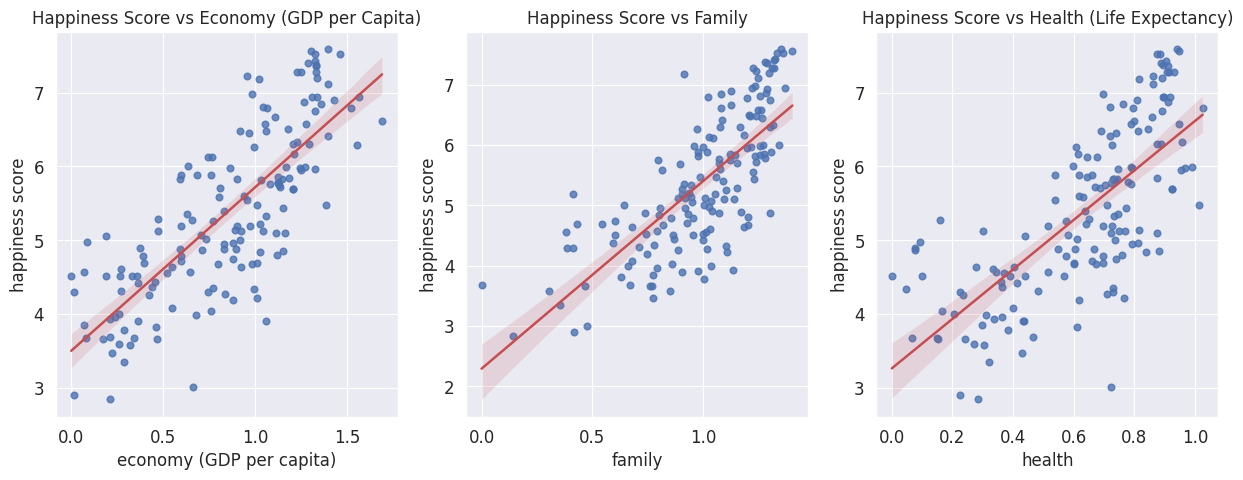

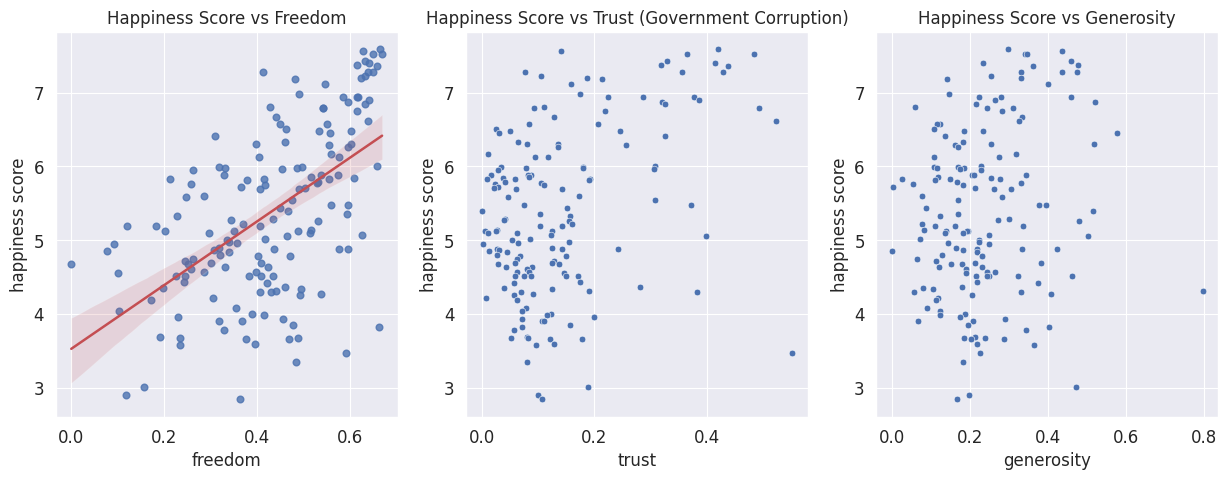

In [166]:
fig = plt.figure(figsize=(10,7))
(topfig,bottomfig) = fig.subfigures(2,1)

topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)
fig,axes = plt.subplots(1,3,figsize=(15,5))
sns.regplot(ax=axes[0],data=data15,x='Economy (GDP per Capita)',y='Happiness Score',line_kws={'color':'r'})
sns.regplot(ax=axes[1],data=data15,x='Family',y='Happiness Score',line_kws={'color':'r'})
sns.regplot(ax=axes[2],data=data15,x='Health (Life Expectancy)',y='Happiness Score',line_kws={'color':'r'})
axes[0].set_title('Happiness Score vs Economy (GDP per Capita)',fontsize=12)
axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].yaxis.set_tick_params(labelsize=12)
axes[0].set_xlabel('economy (GDP per capita)',fontsize=12)
axes[0].set_ylabel('happiness score',fontsize=12)
axes[1].set_title('Happiness Score vs Family',fontsize=12)
axes[1].xaxis.set_tick_params(labelsize=12)
axes[1].yaxis.set_tick_params(labelsize=12)
axes[1].set_xlabel('family',fontsize=12)
axes[1].set_ylabel('happiness score',fontsize=12)
axes[2].set_title('Happiness Score vs Health (Life Expectancy)',fontsize=12)
axes[2].xaxis.set_tick_params(labelsize=12)
axes[2].yaxis.set_tick_params(labelsize=12)
axes[2].set_xlabel('health',fontsize=12)
axes[2].set_ylabel('happiness score',fontsize=12)

bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)
fig,axes = plt.subplots(1,3,figsize=(15,5))
sns.regplot(ax=axes[0],data=data15,x='Freedom',y='Happiness Score',line_kws={'color':'r'})
sns.scatterplot(ax=axes[1],data=data15,x='Trust (Government Corruption)',y='Happiness Score')
sns.scatterplot(ax=axes[2],data=data15,x='Generosity',y='Happiness Score')
axes[0].set_title('Happiness Score vs Freedom',fontsize=12)
axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].yaxis.set_tick_params(labelsize=12)
axes[0].set_xlabel('freedom',fontsize=12)
axes[0].set_ylabel('happiness score',fontsize=12)
axes[1].set_title('Happiness Score vs Trust (Government Corruption)',fontsize=12)
axes[1].xaxis.set_tick_params(labelsize=12)
axes[1].yaxis.set_tick_params(labelsize=12)
axes[1].set_xlabel('trust',fontsize=12)
axes[1].set_ylabel('happiness score',fontsize=12)
axes[2].set_title('Happiness Score vs Generosity',fontsize=12);
axes[2].xaxis.set_tick_params(labelsize=12)
axes[2].yaxis.set_tick_params(labelsize=12)
axes[2].set_xlabel('generosity',fontsize=12)
axes[2].set_ylabel('happiness score',fontsize=12);

In some cases there is a linear correlation between the happiness score and the variables. In the last two cases, there is either no apparent correlation between the happiness score and the variables or there is a quite weak one.

Let plot a Correlation Heatmap and understand further analysis

In [167]:
d15 = data15.drop(['Country','Region','Happiness Rank','Standard Error','Dystopia Residual'],axis=1)

plt.figure(figsize=(15,10))
sns.heatmap(d15.corr(method='pearson'),vmin=-1,vmax=1,annot=True,cmap='coolwarm',annot_kws={"fontsize":14})
sns.set(font_scale=2)
plt.title('Correlation heatmap',fontsize=25)
plt.show();

KeyError: "['Happiness Rank', 'Standard Error'] not found in axis"

It is very interesting to see if there is correlation between the happiness score predictors.

1.  There are some big positive correlations, like that between life expectancy and economy and that between family and economy.
2.  There are also unexpected results, like the almost zero-correlation between economy and generosity. This would indicate that the generosity of a population has nothing to do with its economic status, but it is rather an intrinsic or cultural feature.


Finally, let's see which are the happiest countries in the world in the years 2015 and 2019 ...

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,8))

data_scores15 = data_scores.copy().sort_values(by=['2015_score'],ascending=False).head()

ax1.bar(data_scores15['country'],data_scores15['2015_score'],color='navy',linewidth=3)
ax1.set_title('Happiest Countries in 2015',fontsize=20)
ax1.set_ylabel('happiness score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

data_scores19 = data_scores.copy().sort_values(by=['2019_score'],ascending=False).head()

ax2.bar(data_scores19['country'],data_scores19['2019_score'],color='steelblue',linewidth=3)
ax2.set_title('Happiest Countries in 2019',fontsize=20)
ax2.set_ylabel('happiness score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Highest Happiness Scores",fontsize=28)

plt.tight_layout()

...and the countries with the lowest happiness scores in the world in the years 2015 and 2019.

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,8))

data_scores15 = data_scores.copy().sort_values(by=['2015_score'],ascending=True).head()

ax1.bar(data_scores15['country'],data_scores15['2015_score'],color='navy',linewidth=3)
ax1.set_title('Saddest Countries in 2015',fontsize=20)
ax1.set_ylabel('happiness score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

data_scores19 = data_scores.copy().sort_values(by=['2019_score'],ascending=True).head()

ax2.bar(data_scores19['country'],data_scores19['2019_score'],color='steelblue',linewidth=3)
ax2.set_title('Saddest Countries in 2019',fontsize=20)
ax2.set_ylabel('happiness score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Lowest Happiness Scores",fontsize=28)

plt.tight_layout()

### **4.2 Happiness Scores and Happiness Score Trends in World Regions**

It is interesting to calculate the average happiness score in the different world regions.

In [ ]:
region_score15 = data_scores.groupby('region')['2015_score'].mean().reset_index(name='mean2015').sort_values(['mean2015'],ascending= False)
region_score16 = data_scores.groupby('region')['2016_score'].mean().reset_index(name='mean2016').sort_values(['mean2016'],ascending= False)
region_score17 = data_scores.groupby('region')['2017_score'].mean().reset_index(name='mean2017').sort_values(['mean2017'],ascending= False)
region_score18 = data_scores.groupby('region')['2018_score'].mean().reset_index(name='mean2018').sort_values(['mean2018'],ascending= False)
region_score19 = data_scores.groupby('region')['2019_score'].mean().reset_index(name='mean2019').sort_values(['mean2019'],ascending= False)

region_score = region_score15.copy()
region_score = region_score.merge(region_score16,on=['region'])
region_score = region_score.merge(region_score17,on=['region'])
region_score = region_score.merge(region_score18,on=['region'])
region_score = region_score.merge(region_score19,on=['region'])
region_score['diff mean 2015-2019'] = region_score['mean2019'] - region_score['mean2015']

region_score

In the above table, one can read the mean happiness scores for different regions for the years 2015 - 2019, including the difference between the 2015 and 2019 values (last column).

Now I am plotting the average values of the 2015 and 2019 happiness scores for these areas.

In [ ]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,9))

ax1.bar(region_score['region'],region_score['mean2015'],color='navy',linewidth=3)
ax1.set_title('2015 Happiness Score',fontsize=20)
ax1.set_ylabel('happiness score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

ax2.bar(region_score['region'],region_score['mean2019'],color='steelblue',linewidth=3)
ax2.set_title('2019 Happiness Score',fontsize=20)
ax2.set_ylabel('happiness score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Average Happiness Scores in Different World Regions",fontsize=28)

plt.tight_layout()

There are some differences between the 2015 and 2019 averages. One of them is the grow in the happiness score of Western Europe, which got closer to that of North America and Australia.

By having a look at the table also, one can see that some values keep oscillating, like those of Southern and Southestern Asia. On the contrary, in other areas there is a visible upward/downward trend, like in the case of Sub-Saharan Africa and North America. It would be very interesting to investigate the reasons behind this and also if the variabiliy in those trends is even wider on larger time frames.

These effects could be due to globalization, which can change the economic perspectives of a country (and therefore its level of happiness) faster than ever.

In [ ]:
x = [2015,2016,2017,2018,2019]
y1 = [7.285000,7.323500,7.299000,7.298000,7.267500]
y2 = [7.273000,7.254000,7.154500,7.107000,7.085000]
y3 = [6.739350,6.731400,6.748400,6.829100,6.898400]
y4 = [6.137300,6.050500,5.947400,5.937750,5.942550]
y5 = [5.496250,5.477000,5.496500,5.540250,5.564250]
y6 = [5.372625,5.396750,5.444875,5.399750,5.333375]
y7 = [5.344571,5.379607,5.418321,5.473929,5.571786]
y8 = [5.330789,5.386053,5.369684,5.282737,5.237000]
y9 = [4.580857,4.563286,4.628429,4.603857,4.526857]
y10 = [4.120419,4.074839,4.131129,4.247968,4.380323]

plt.figure(figsize=(12,6))
plt.plot(x,y1,'-o',label='Australia and New Zealand')
plt.plot(x,y2,'-o',label='North America')
plt.plot(x,y3,'-o',label='Western Europe')
plt.plot(x,y4,'-o',label='Latin America and Caribbean')
plt.plot(x,y5,'-o',label='Eastern Asia')
plt.plot(x,y6,'-o',label='Southeastern Asia')
plt.plot(x,y7,'-o',label='Central and Eastern Europe')
plt.plot(x,y8,'-o',label='Middle East and Northern Africa')
plt.plot(x,y9,'-o',label='Southern Asia')
plt.plot(x,y10,'-o',label='Sub-Saharan Africa')

plt.title('Happiness Scores in 2015-2019')
plt.xticks(fontsize=14)
plt.legend(loc='upper left',fontsize=8);


**Countries with best and worst performances in 2015-2019**

I am introducing a new column with the 2015-2019 difference in happiness scores.

In [168]:
data_scores['diff1519'] = data_scores['2019_score'] - data_scores['2015_score']

These are the five countries with the worst performances in the 2015-2019 period. They are all in the Latin America and Caribbean or Sub-Saharan Africa regions.

In [169]:
best_worst = data_scores[['country','region','diff1519']]
best_worst = best_worst.sort_values(by=['diff1519'],ascending=True)

best_worst.head()

country                       region  diff1519
21   Venezuela  Latin America and Caribbean    -2.103
78      Zambia           Sub-Saharan Africa    -1.022
102   Zimbabwe           Sub-Saharan Africa    -0.947
105      Haiti  Latin America and Caribbean    -0.921
116     Malawi           Sub-Saharan Africa    -0.882

These are the five countries with the best performances in the 2015-2019 period. Again, they are all in the Latin America and Caribbean or Sub-Saharan Africa regions. This means that the highest variations can be expected from developing countries.

In [170]:
best_worst = best_worst.sort_values(by=['diff1519'],ascending=False)

best_worst.head()

country                       region  diff1519
137         Benin           Sub-Saharan Africa     1.543
133   Ivory Coast           Sub-Saharan Africa     1.289
140          Togo           Sub-Saharan Africa     1.246
92       Honduras  Latin America and Caribbean     1.072
134  Burkina Faso           Sub-Saharan Africa     1.000

### **4.3 Economy Score/GDP**

Let's start with a world map of the 2015 'Economy Score' (i.e. GDP per capita).

In [171]:
economy_scores = pd.DataFrame()
e16 = pd.DataFrame()
e17 = pd.DataFrame()
e18 = pd.DataFrame()
e19 = pd.DataFrame()

economy_scores[['country','region','2015_GDP_score','2015_score']] = data15[['Country','Region','Economy (GDP per Capita)','Happiness Score']]

e16[['country','2016_GDP_score','2016_score']] = data16[['Country','Economy (GDP per Capita)','Happiness Score']]
e17[['country','2017_GDP_score','2017_score']] = data17[['Country','Economy..GDP.per.Capita.','Happiness.Score']]
e18[['country','2018_GDP_score','2018_score']] = data18[['Country or region','GDP per capita','Score']]
e19[['country','2019_GDP_score','2019_score']] = data19[['Country or region','GDP per capita','Score']]

economy_scores = economy_scores.merge(e16,on=['country'])
economy_scores = economy_scores.merge(e17,on=['country'])
economy_scores = economy_scores.merge(e18,on=['country'])
economy_scores = economy_scores.merge(e19,on=['country'])

economy_scores.head()

country          region  2015_GDP_score  2015_score  2016_GDP_score  \
0  Switzerland  Western Europe         1.39651       7.587         1.52733   
1      Iceland  Western Europe         1.30232       7.561         1.42666   
2      Denmark  Western Europe         1.32548       7.527         1.44178   
3       Norway  Western Europe         1.45900       7.522         1.57744   
4       Canada   North America         1.32629       7.427         1.44015   

   2016_score  2017_GDP_score  2017_score  2018_GDP_score  2018_score  \
0       7.509        1.564980       7.494           1.420       7.487   
1       7.501        1.480633       7.504           1.343       7.495   
2       7.526        1.482383       7.522           1.351       7.555   
3       7.498        1.616463       7.537           1.456       7.594   
4       7.404        1.479204       7.316           1.330       7.328   

   2019_GDP_score  2019_score  
0           1.452       7.480  
1           1.380       7.494  
2           1.383       7.600  
3           1.488       7.554  
4           1.365       7.278

In [172]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = economy_scores['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Greens',
            text = economy_scores['country'],
            z = economy_scores['2015_GDP_score'],
            colorbar = {'title':'GDP score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
gdp_map = gobj.Figure(data=[data])

gdp_map.update_layout(title_text = 'Economy (GDP) Score by Country (Year 2015)')

#plotting the map
iplot(gdp_map)

Now, like we did with the happiness score, let's plot the average values of the GDP (or economy) scores of the world's regions for the years 2015 and 2019.

In [173]:
economy_region_score = economy_scores.groupby('region')['2015_GDP_score'].mean().reset_index(name='GDP2015').sort_values(['GDP2015'],ascending=False)
rscore16 = economy_scores.groupby('region')['2016_GDP_score'].mean().reset_index(name='GDP2016').sort_values(['GDP2016'],ascending=False)
rscore17 = economy_scores.groupby('region')['2017_GDP_score'].mean().reset_index(name='GDP2017').sort_values(['GDP2017'],ascending=False)
rscore18 = economy_scores.groupby('region')['2018_GDP_score'].mean().reset_index(name='GDP2018').sort_values(['GDP2018'],ascending=False)
rscore19 = economy_scores.groupby('region')['2019_GDP_score'].mean().reset_index(name='GDP2019').sort_values(['GDP2019'],ascending=False)

economy_region_score = economy_region_score.merge(rscore16,on=['region'])
economy_region_score = economy_region_score.merge(rscore17,on=['region'])
economy_region_score = economy_region_score.merge(rscore18,on=['region'])
economy_region_score = economy_region_score.merge(rscore19,on=['region'])
economy_region_score['diff GDP 2015-2019'] = economy_region_score['GDP2019'] - economy_region_score['GDP2015']

economy_region_score

region   GDP2015   GDP2016   GDP2017   GDP2018  \
0                    North America  1.360400  1.474055  1.512732  1.364000   
1                   Western Europe  1.303122  1.422338  1.462936  1.325650   
2        Australia and New Zealand  1.291880  1.402545  1.445060  1.304000   
3                     Eastern Asia  1.058415  1.188970  1.231749  1.115750   
4  Middle East and Northern Africa  1.051545  1.139323  1.168535  1.081158   
5       Central and Eastern Europe  0.943293  1.048545  1.093032  0.990429   
6      Latin America and Caribbean  0.854139  0.959183  0.994212  0.889950   
7                Southeastern Asia  0.813854  0.923376  0.965253  0.915750   
8                    Southern Asia  0.560486  0.660671  0.697479  0.625143   
9               Sub-Saharan Africa  0.381394  0.473830  0.513245  0.452613   

    GDP2019  diff GDP 2015-2019  
0  1.399000            0.038600  
1  1.362050            0.058928  
2  1.337500            0.045620  
3  1.151250            0.092835  
4  1.059053            0.007507  
5  1.022429            0.079136  
6  0.908950            0.054811  
7  0.950750            0.136896  
8  0.650286            0.089800  
9  0.466226            0.084832

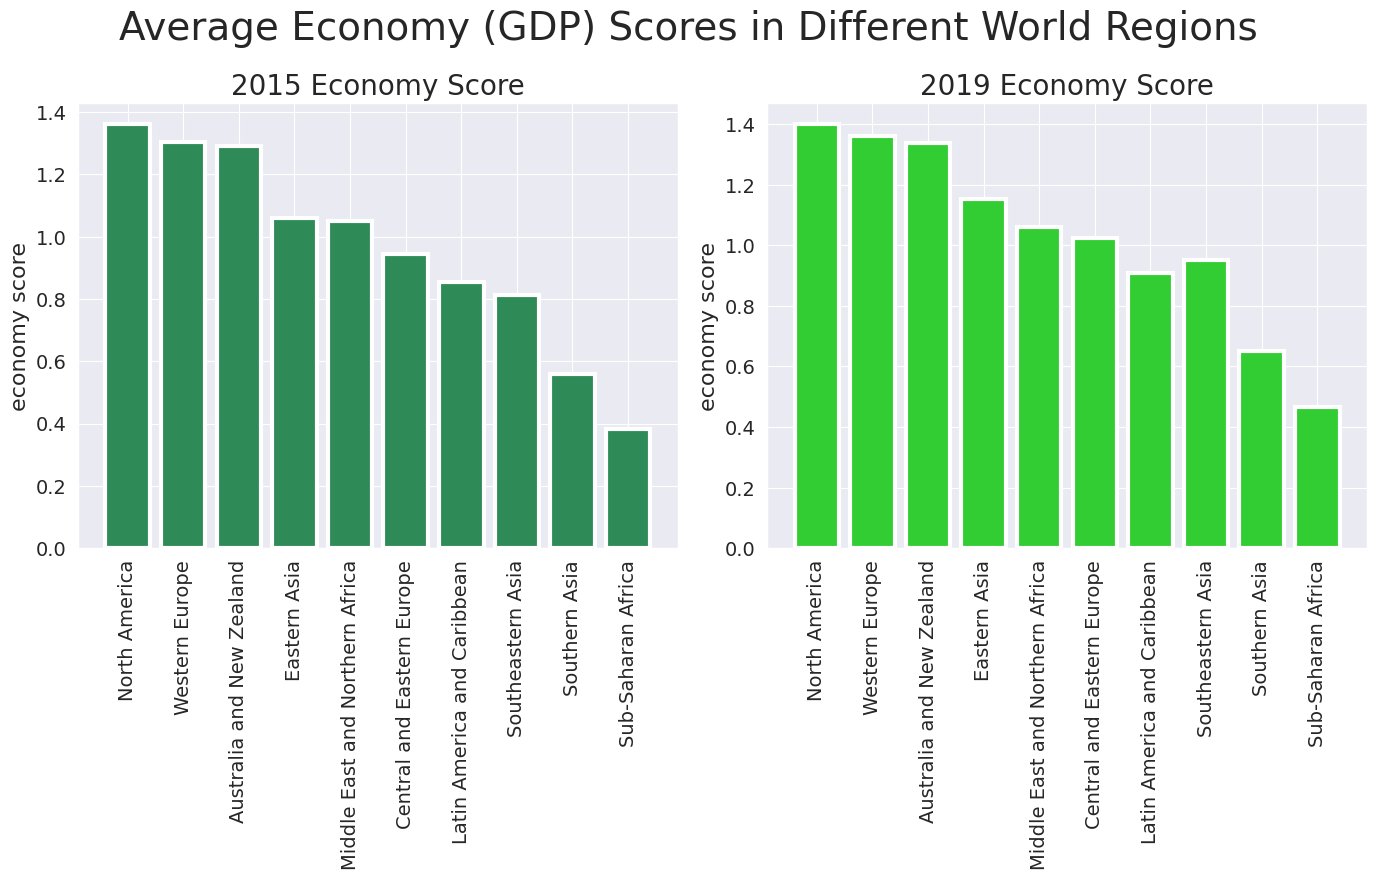

In [174]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,9))

ax1.bar(economy_region_score['region'],economy_region_score['GDP2015'],color='seagreen',linewidth=3)
ax1.set_title('2015 Economy Score',fontsize=20)
ax1.set_ylabel('economy score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

ax2.bar(economy_region_score['region'],economy_region_score['GDP2019'],color='limegreen',linewidth=3)
ax2.set_title('2019 Economy Score',fontsize=20)
ax2.set_ylabel('economy score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Average Economy (GDP) Scores in Different World Regions",fontsize=28)

plt.tight_layout()

There are some clear variations in the average economy scores between 2015 and 2019. To have a clearer picture of this, let's see what are the economic trends for the 2015-2019 period.

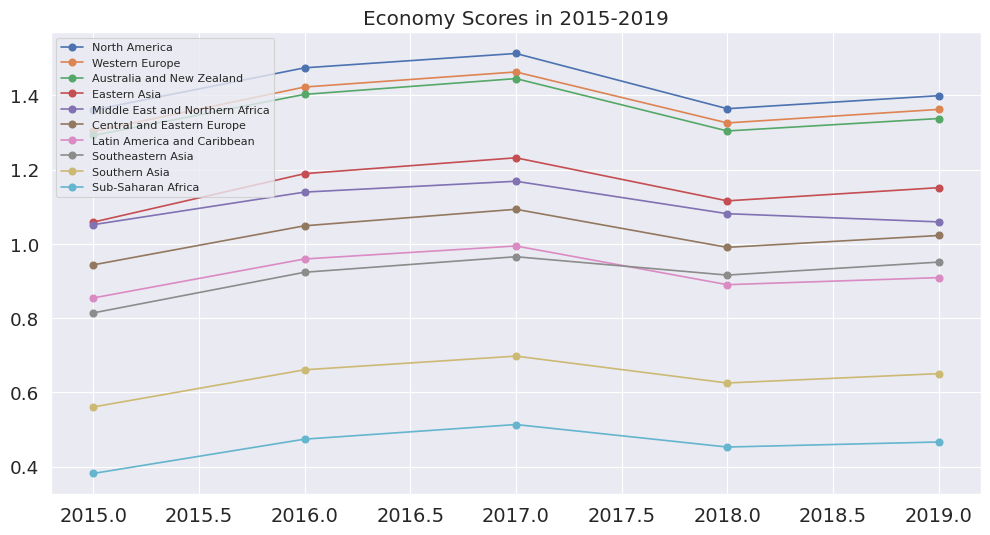

In [175]:
x = [2015,2016,2017,2018,2019]
y1 = [1.360400,1.474055,1.512732,1.364000,1.399000]
y2 = [1.303122,1.422338,1.462936,1.325650,1.362050]
y3 = [1.291880,1.402545,1.445060,1.304000,1.337500]
y4 = [1.058415,1.188970,1.231749,1.115750,1.151250]
y5 = [1.051545,1.139323,1.168535,1.081158,1.059053]
y6 = [0.943293,1.048545,1.093032,0.990429,1.022429]
y7 = [0.854139,0.959183,0.994212,0.889950,0.908950]
y8 = [0.813854,0.923376,0.965253,0.915750,0.950750]
y9 = [0.560486,0.660671,0.697479,0.625143,0.650286]
y10 = [0.381394,0.473830,0.513245,0.452613,0.466226]

plt.figure(figsize=(12,6))
plt.plot(x,y1,'-o',label='North America')
plt.plot(x,y2,'-o',label='Western Europe')
plt.plot(x,y3,'-o',label='Australia and New Zealand')
plt.plot(x,y4,'-o',label='Eastern Asia')
plt.plot(x,y5,'-o',label='Middle East and Northern Africa')
plt.plot(x,y6,'-o',label='Central and Eastern Europe')
plt.plot(x,y7,'-o',label='Latin America and Caribbean')
plt.plot(x,y8,'-o',label='Southeastern Asia')
plt.plot(x,y9,'-o',label='Southern Asia')
plt.plot(x,y10,'-o',label='Sub-Saharan Africa')

plt.title('Economy Scores in 2015-2019')
plt.xticks(fontsize=14)
plt.legend(loc='upper left',fontsize=8);

It is very interesting to observe that the scores for the different world areas go up and down year after year at almost exactly the same rhythm. This is a clear indication of the fact that all the world economies are strongly interconnected one another.

### **4.4 Health**

Let's move to the health score. Due to the strong correlation between the health and the economy and happiness scores, I expect to see rich and 'happy' countries high in the chart.

However, there are also other metrics that determine the health of a population besides economy and 'happiness', including the diet and maybe also the type of climate. This is why Italy and Japan are expected to be very high in this chart.

In [176]:
health_scores = pd.DataFrame()
h16 = pd.DataFrame()
h17 = pd.DataFrame()
h18 = pd.DataFrame()
h19 = pd.DataFrame()

health_scores[['country','region','2015_health_score','2015_score']] = data15[['Country','Region','Health (Life Expectancy)','Happiness Score']]
h16[['country','2016_health_score','2016_score']] = data16[['Country','Health (Life Expectancy)','Happiness Score']]
h17[['country','2017_health_score','2017_score']] = data17[['Country','Health..Life.Expectancy.','Happiness.Score']]
h18[['country','2018_health_score','2018_score']] = data18[['Country or region','Healthy life expectancy','Score']]
h19[['country','2019_health_score','2019_score']] = data19[['Country or region','Healthy life expectancy','Score']]

health_scores = health_scores.merge(h16,on=['country'])
health_scores = health_scores.merge(h17,on=['country'])
health_scores = health_scores.merge(h18,on=['country'])
health_scores = health_scores.merge(h19,on=['country'])

health_scores.head(5)

country          region  2015_health_score  2015_score  \
0  Switzerland  Western Europe            0.94143       7.587   
1      Iceland  Western Europe            0.94784       7.561   
2      Denmark  Western Europe            0.87464       7.527   
3       Norway  Western Europe            0.88521       7.522   
4       Canada   North America            0.90563       7.427   

   2016_health_score  2016_score  2017_health_score  2017_score  \
0            0.86303       7.509           0.858131       7.494   
1            0.86733       7.501           0.833552       7.504   
2            0.79504       7.526           0.792566       7.522   
3            0.79579       7.498           0.796667       7.537   
4            0.82760       7.404           0.834558       7.316   

   2018_health_score  2018_score  2019_health_score  2019_score  
0              0.927       7.487              1.052       7.480  
1              0.914       7.495              1.026       7.494  
2              0.868       7.555              0.996       7.600  
3              0.861       7.594              1.028       7.554  
4              0.896       7.328              1.039       7.278

In [177]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = health_scores['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Reds',
            text = health_scores['country'],
            z = health_scores['2015_health_score'],
            colorbar = {'title':'health score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
health_map = gobj.Figure(data=[data])

health_map.update_layout(title_text = 'Health Score by Country (Year 2015)')

#plotting the map
iplot(health_map)

Now, let's see which are the highest ranking countries in health.

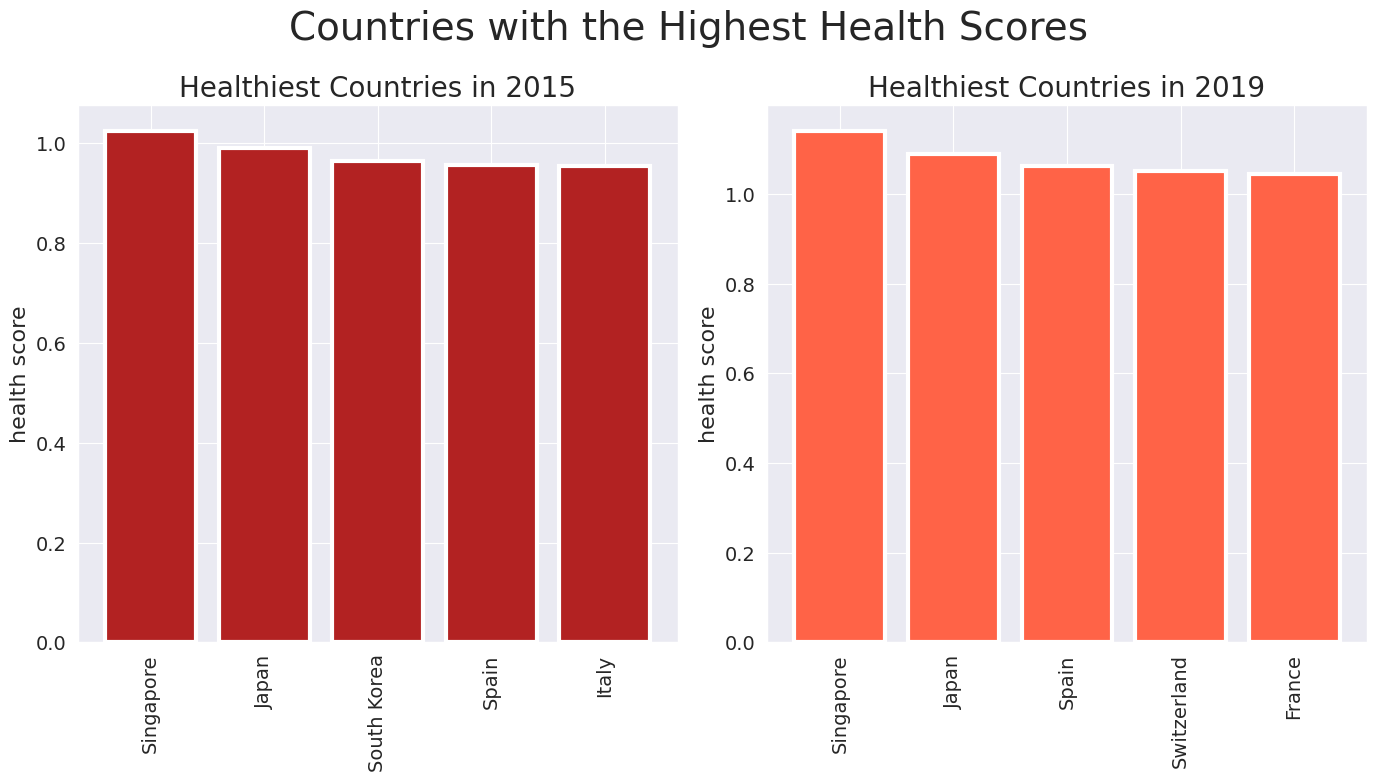

In [178]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,8))

health_scores15 = health_scores.copy().sort_values(by=['2015_health_score'],ascending=False).head()

ax1.bar(health_scores15['country'],health_scores15['2015_health_score'],color='firebrick',linewidth=3)
ax1.set_title('Healthiest Countries in 2015',fontsize=20)
ax1.set_ylabel('health score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

health_scores19 = health_scores.copy().sort_values(by=['2019_health_score'],ascending=False).head()

ax2.bar(health_scores19['country'],health_scores19['2019_health_score'],color='tomato',linewidth=3)
ax2.set_title('Healthiest Countries in 2019',fontsize=20)
ax2.set_ylabel('health score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Highest Health Scores",fontsize=28)

plt.tight_layout()

Now, we will have a look at the average health scores by world region.

In [179]:
health_region_score = health_scores.groupby('region')['2015_health_score'].mean().reset_index(name='health2015').sort_values(['health2015'],ascending=False)
hscore16 = health_scores.groupby('region')['2016_health_score'].mean().reset_index(name='health2016').sort_values(['health2016'],ascending=False)
hscore17 = health_scores.groupby('region')['2017_health_score'].mean().reset_index(name='health2017').sort_values(['health2017'],ascending=False)
hscore18 = health_scores.groupby('region')['2018_health_score'].mean().reset_index(name='health2018').sort_values(['health2018'],ascending=False)
hscore19 = health_scores.groupby('region')['2019_health_score'].mean().reset_index(name='health2019').sort_values(['health2019'],ascending=False)

health_region_score = health_region_score.merge(hscore16,on=['region'])
health_region_score = health_region_score.merge(hscore17,on=['region'])
health_region_score = health_region_score.merge(hscore18,on=['region'])
health_region_score = health_region_score.merge(hscore19,on=['region'])

health_region_score

region  health2015  health2016  health2017  \
0        Australia and New Zealand    0.919965    0.841080    0.830323   
1                   Western Europe    0.908427    0.824971    0.824175   
2                    North America    0.883710    0.803300    0.804422   
3                     Eastern Asia    0.843938    0.772915    0.778222   
4       Central and Eastern Europe    0.718178    0.631028    0.635773   
5      Latin America and Caribbean    0.713106    0.621809    0.623601   
6  Middle East and Northern Africa    0.702608    0.616438    0.605980   
7                Southeastern Asia    0.693390    0.583676    0.581918   
8                    Southern Asia    0.540830    0.453670    0.456658   
9               Sub-Saharan Africa    0.299445    0.242479    0.247857   

   health2018  health2019  
0    0.893000    1.031000  
1    0.895800    1.013850  
2    0.857500    0.956500  
3    0.829250    0.921000  
4    0.686536    0.808500  
5    0.666250    0.816800  
6    0.646632    0.751053  
7    0.625875    0.769625  
8    0.497286    0.617000  
9    0.279484    0.440839

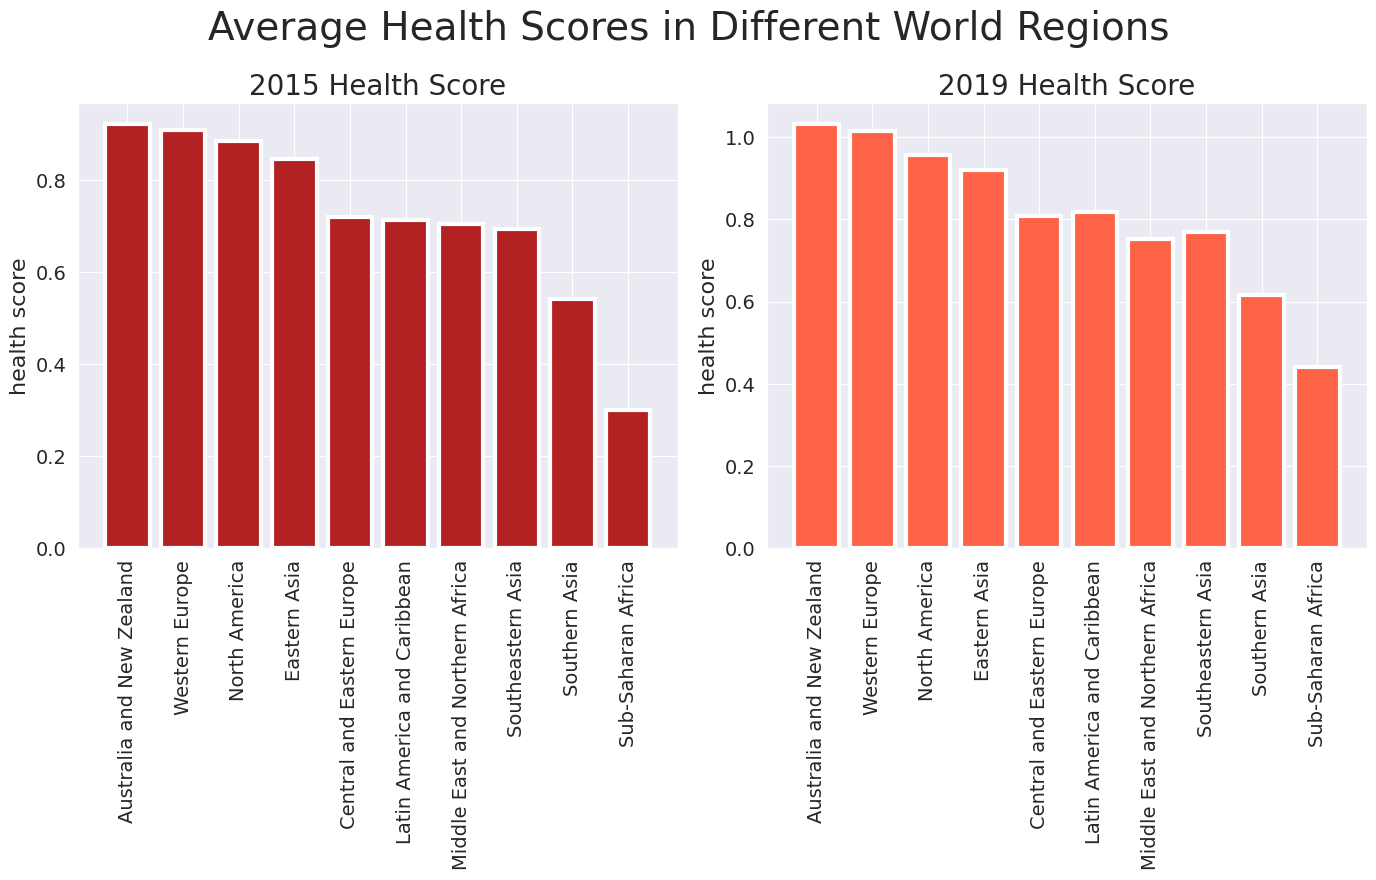

In [180]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,9))

ax1.bar(health_region_score['region'],health_region_score['health2015'],color='firebrick',linewidth=3)
ax1.set_title('2015 Health Score',fontsize=20)
ax1.set_ylabel('health score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

ax2.bar(health_region_score['region'],health_region_score['health2019'],color='tomato',linewidth=3)
ax2.set_title('2019 Health Score',fontsize=20)
ax2.set_ylabel('health score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Average Health Scores in Different World Regions",fontsize=28)

plt.tight_layout()

It is strange not to see Western Europe on top of the 2019 health chart, given that there are three Western European countries in the top five. Even Eastern Asia might be higher in the 2019 chart, given that Japan and Singapore are world #1 and #2.

Let's plot the health score map for Western Europe to see if there are potentially 'unhealthy' countries that lower the regional score.

In [181]:
health_scores_europe = health_scores[(health_scores['region'] == 'Western Europe') | (health_scores['region'] == 'Central and Eastern Europe')]

#Initializing the data variable
data = dict(type = 'choropleth',
            locations = health_scores_europe['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Reds',
            text = health_scores_europe['country'],
            z = health_scores_europe['2019_health_score'],
            colorbar = {'title':'health score','len':0.75,'lenmode':'fraction'})

#Initializing the layout variable
layout = dict(geo=dict(scope='europe'))

#Initializing the object for graph_objs.Figure class
health_europe = gobj.Figure(data=[data],layout=layout)

health_europe.update_layout(title_text = 'Health Score in Europe (Year 2019)')

#plotting the map
iplot(health_europe)

There is not a large difference in the health scores among the countries of Western Europe. Probably the match with Australia and New Zealand was a really close one. On the contrary, the countries from Eastern Europe are by far less healthy.

### **4.5 Freedom**

The freedom score has a low/medium correlation with the economy score; the correlation it has with the happiness score is higher. This is interesting: we may have surprising countries at the top of the chart.

In [182]:
freedom_scores = pd.DataFrame()
f16 = pd.DataFrame()
f17 = pd.DataFrame()
f18 = pd.DataFrame()
f19 = pd.DataFrame()

freedom_scores[['country','region','2015_freedom_score','2015_score']] = data15[['Country','Region','Freedom','Happiness Score']]

f16[['country','2016_freedom_score','2016_score']] = data16[['Country','Freedom','Happiness Score']]
f17[['country','2017_freedom_score','2017_score']] = data17[['Country','Freedom','Happiness.Score']]
f18[['country','2018_freedom_score','2018_score']] = data18[['Country or region','Freedom to make life choices','Score']]
f19[['country','2019_freedom_score','2019_score']] = data19[['Country or region','Freedom to make life choices','Score']]

freedom_scores = freedom_scores.merge(f16,on=['country'])
freedom_scores = freedom_scores.merge(f17,on=['country'])
freedom_scores = freedom_scores.merge(f18,on=['country'])
freedom_scores = freedom_scores.merge(f19,on=['country'])

freedom_scores.head()

country          region  2015_freedom_score  2015_score  \
0  Switzerland  Western Europe             0.66557       7.587   
1      Iceland  Western Europe             0.62877       7.561   
2      Denmark  Western Europe             0.64938       7.527   
3       Norway  Western Europe             0.66973       7.522   
4       Canada   North America             0.63297       7.427   

   2016_freedom_score  2016_score  2017_freedom_score  2017_score  \
0             0.58557       7.509            0.620071       7.494   
1             0.56624       7.501            0.627163       7.504   
2             0.57941       7.526            0.626007       7.522   
3             0.59609       7.498            0.635423       7.537   
4             0.57370       7.404            0.611101       7.316   

   2018_freedom_score  2018_score  2019_freedom_score  2019_score  
0               0.660       7.487               0.572       7.480  
1               0.677       7.495               0.591       7.494  
2               0.683       7.555               0.592       7.600  
3               0.686       7.594               0.603       7.554  
4               0.653       7.328               0.584       7.278

In [183]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = freedom_scores['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Greys',
            text = freedom_scores['country'],
            z = freedom_scores['2015_freedom_score'],
            colorbar = {'title':'freedom score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
freedom_map = gobj.Figure(data=[data])

freedom_map.update_layout(title_text = 'Freedom Score by Country (Year 2015)')

#plotting the map
iplot(freedom_map)

Let's see what are the countries with the largest freedom scores in 2015 and 2019.

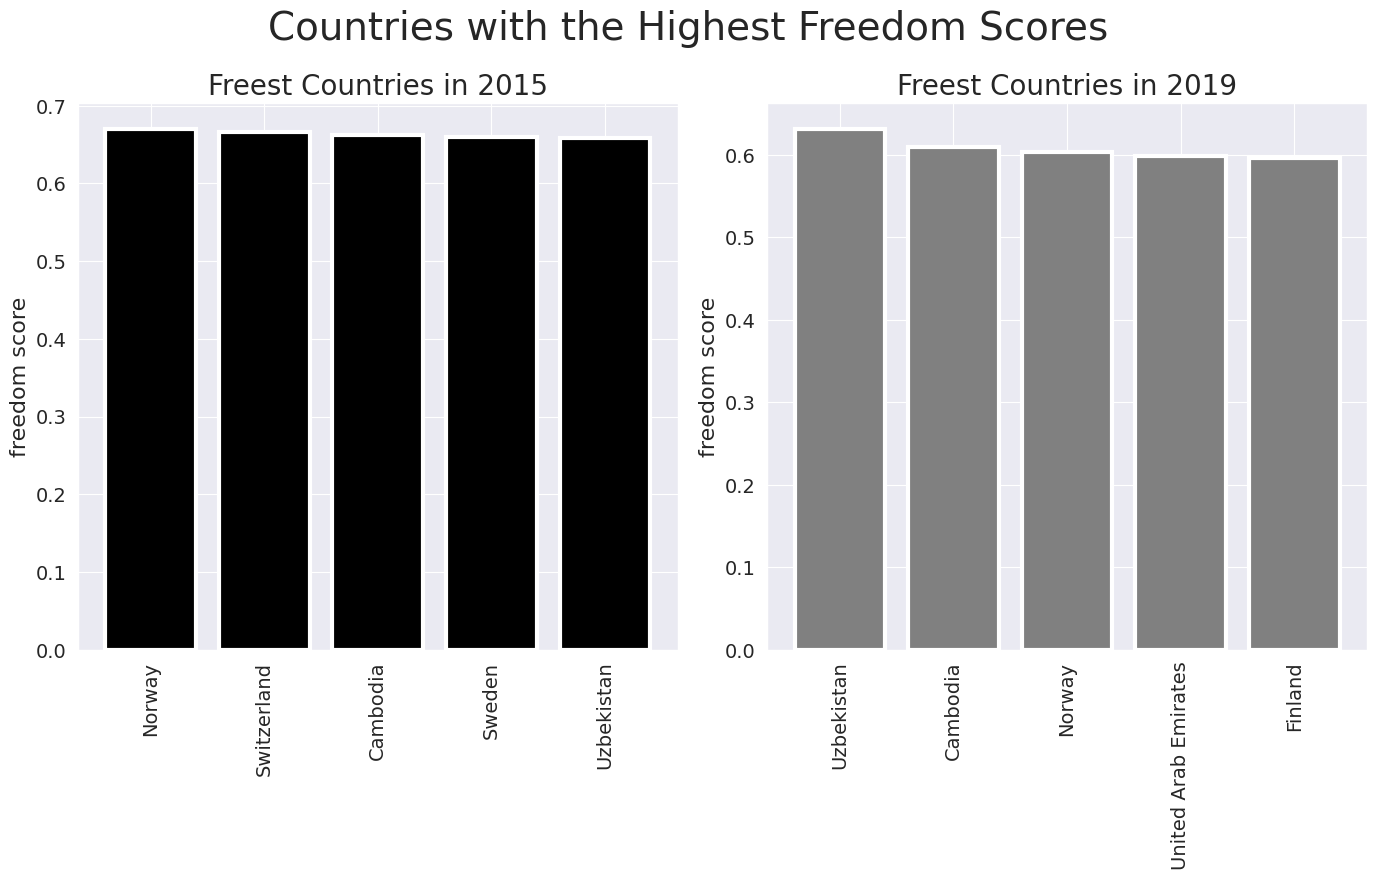

In [184]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,9))

freedom_scores15 = freedom_scores.copy().sort_values(by=['2015_freedom_score'],ascending=False).head()

ax1.bar(freedom_scores15['country'],freedom_scores15['2015_freedom_score'],color='black',linewidth=3)
ax1.set_title('Freest Countries in 2015',fontsize=20)
ax1.set_ylabel('freedom score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

freedom_scores19 = freedom_scores.copy().sort_values(by=['2019_freedom_score'],ascending=False).head()

ax2.bar(freedom_scores19['country'],freedom_scores19['2019_freedom_score'],color='grey',linewidth=3)
ax2.set_title('Freest Countries in 2019',fontsize=20)
ax2.set_ylabel('freedom score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Highest Freedom Scores",fontsize=28)

plt.tight_layout()

### **4.6 Generosity**

In my opinion, this is one of the most important categories. As mentioned before, there is almost zero-correlation between economy and generosity. This would indicate that the generosity of a population has nothing to do with its economic status, but it is rather an intrinsic or cultural feature.

Let's see what are the most generous countries in the world!

In [185]:
generosity_scores = pd.DataFrame()
g16 = pd.DataFrame()
g17 = pd.DataFrame()
g18 = pd.DataFrame()
g19 = pd.DataFrame()

generosity_scores[['country','region','2015_generosity_score','2015_score']] = data15[['Country','Region','Generosity','Happiness Score']]

g16[['country','2016_generosity_score','2016_score']] = data16[['Country','Generosity','Happiness Score']]
g17[['country','2017_generosity_score','2017_score']] = data17[['Country','Generosity','Happiness.Score']]
g18[['country','2018_generosity_score','2018_score']] = data18[['Country or region','Generosity','Score']]
g19[['country','2019_generosity_score','2019_score']] = data19[['Country or region','Generosity','Score']]

generosity_scores = generosity_scores.merge(g16,on=['country'])
generosity_scores = generosity_scores.merge(g17,on=['country'])
generosity_scores = generosity_scores.merge(g18,on=['country'])
generosity_scores = generosity_scores.merge(g19,on=['country'])

generosity_scores.head()

country          region  2015_generosity_score  2015_score  \
0  Switzerland  Western Europe                0.29678       7.587   
1      Iceland  Western Europe                0.43630       7.561   
2      Denmark  Western Europe                0.34139       7.527   
3       Norway  Western Europe                0.34699       7.522   
4       Canada   North America                0.45811       7.427   

   2016_generosity_score  2016_score  2017_generosity_score  2017_score  \
0                0.28083       7.509               0.290549       7.494   
1                0.47678       7.501               0.475540       7.504   
2                0.36171       7.526               0.355280       7.522   
3                0.37895       7.498               0.362012       7.537   
4                0.44834       7.404               0.435540       7.316   

   2018_generosity_score  2018_score  2019_generosity_score  2019_score  
0                  0.256       7.487                  0.263       7.480  
1                  0.353       7.495                  0.354       7.494  
2                  0.284       7.555                  0.252       7.600  
3                  0.286       7.594                  0.271       7.554  
4                  0.321       7.328                  0.285       7.278

In [186]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = generosity_scores['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'Oranges',
            text = generosity_scores['country'],
            z = generosity_scores['2019_generosity_score'],
            colorbar = {'title':'generosity score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
generosity_map = gobj.Figure(data=[data])

generosity_map.update_layout(title_text = 'Generosity Score by Country (Year 2019)')

#plotting the map
iplot(generosity_map)

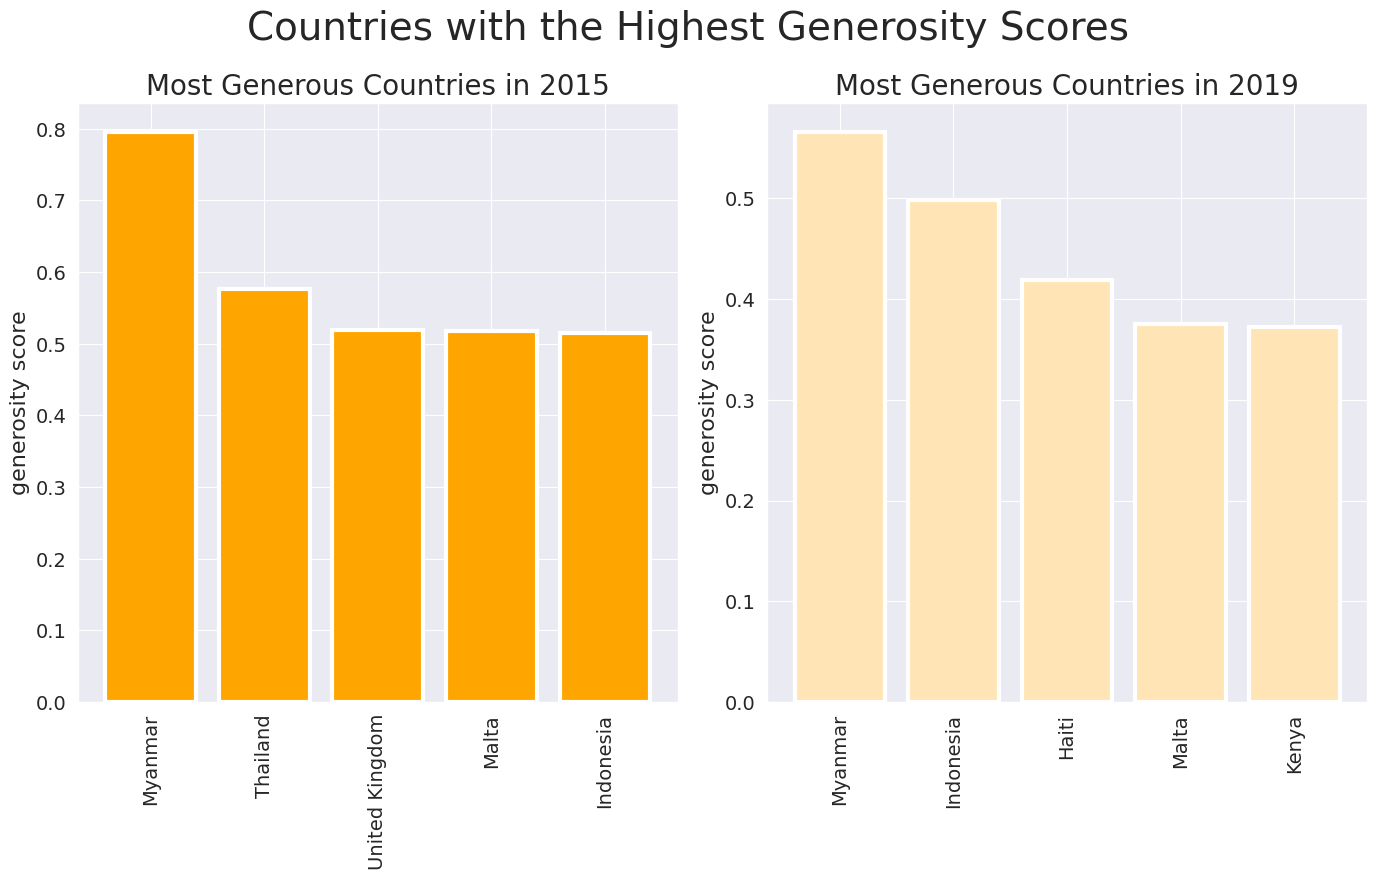

In [187]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,9))

generosity_scores15 = generosity_scores.copy().sort_values(by=['2015_generosity_score'],ascending=False).head()

ax1.bar(generosity_scores15['country'],generosity_scores15['2015_generosity_score'],color='orange',linewidth=3)
ax1.set_title('Most Generous Countries in 2015',fontsize=20)
ax1.set_ylabel('generosity score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

generosity_scores19 = generosity_scores.copy().sort_values(by=['2019_generosity_score'],ascending=False).head()

ax2.bar(generosity_scores19['country'],generosity_scores19['2019_generosity_score'],color='moccasin',linewidth=3)
ax2.set_title('Most Generous Countries in 2019',fontsize=20)
ax2.set_ylabel('generosity score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Highest Generosity Scores",fontsize=28)

plt.tight_layout()

Big up to Myanmar, the most generous country in the world.

### **4.7 Social Support/Family**

This is a very important feature. It is strongly correlated to the target variable (happyness) and to the GDP per capita and has a medium-level correlation to health. Richer countries are expected to be high in this chart.

In [188]:
social_scores = pd.DataFrame()
s16 = pd.DataFrame()
s17 = pd.DataFrame()
s18 = pd.DataFrame()
s19 = pd.DataFrame()

social_scores[['country','region','2015_social_score','2015_score']] = data15[['Country','Region','Family','Happiness Score']]
s16[['country','2016_social_score','2016_score']] = data16[['Country','Family','Happiness Score']]
s17[['country','2017_social_score','2017_score']] = data17[['Country','Family','Happiness.Score']]
s18[['country','2018_social_score','2018_score']] = data18[['Country or region','Social support','Score']]
s19[['country','2019_social_score','2019_score']] = data19[['Country or region','Social support','Score']]

social_scores = social_scores.merge(s16,on=['country'])
social_scores = social_scores.merge(s17,on=['country'])
social_scores = social_scores.merge(s18,on=['country'])
social_scores = social_scores.merge(s19,on=['country'])

social_scores.head(5)

country          region  2015_social_score  2015_score  \
0  Switzerland  Western Europe            1.34951       7.587   
1      Iceland  Western Europe            1.40223       7.561   
2      Denmark  Western Europe            1.36058       7.527   
3       Norway  Western Europe            1.33095       7.522   
4       Canada   North America            1.32261       7.427   

   2016_social_score  2016_score  2017_social_score  2017_score  \
0            1.14524       7.509           1.516912       7.494   
1            1.18326       7.501           1.610574       7.504   
2            1.16374       7.526           1.551122       7.522   
3            1.12690       7.498           1.533524       7.537   
4            1.09610       7.404           1.481349       7.316   

   2018_social_score  2018_score  2019_social_score  2019_score  
0              1.549       7.487              1.526       7.480  
1              1.644       7.495              1.624       7.494  
2              1.590       7.555              1.573       7.600  
3              1.582       7.594              1.582       7.554  
4              1.532       7.328              1.505       7.278

In [189]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = social_scores['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = "Cividis",
            text = social_scores['country'],
            z = social_scores['2015_social_score'],
            colorbar = {'title':'social support score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
social_map = gobj.Figure(data=[data])

social_map.update_layout(title_text = 'Social Support Score by Country (Year 2015)')

#plotting the map
iplot(social_map)

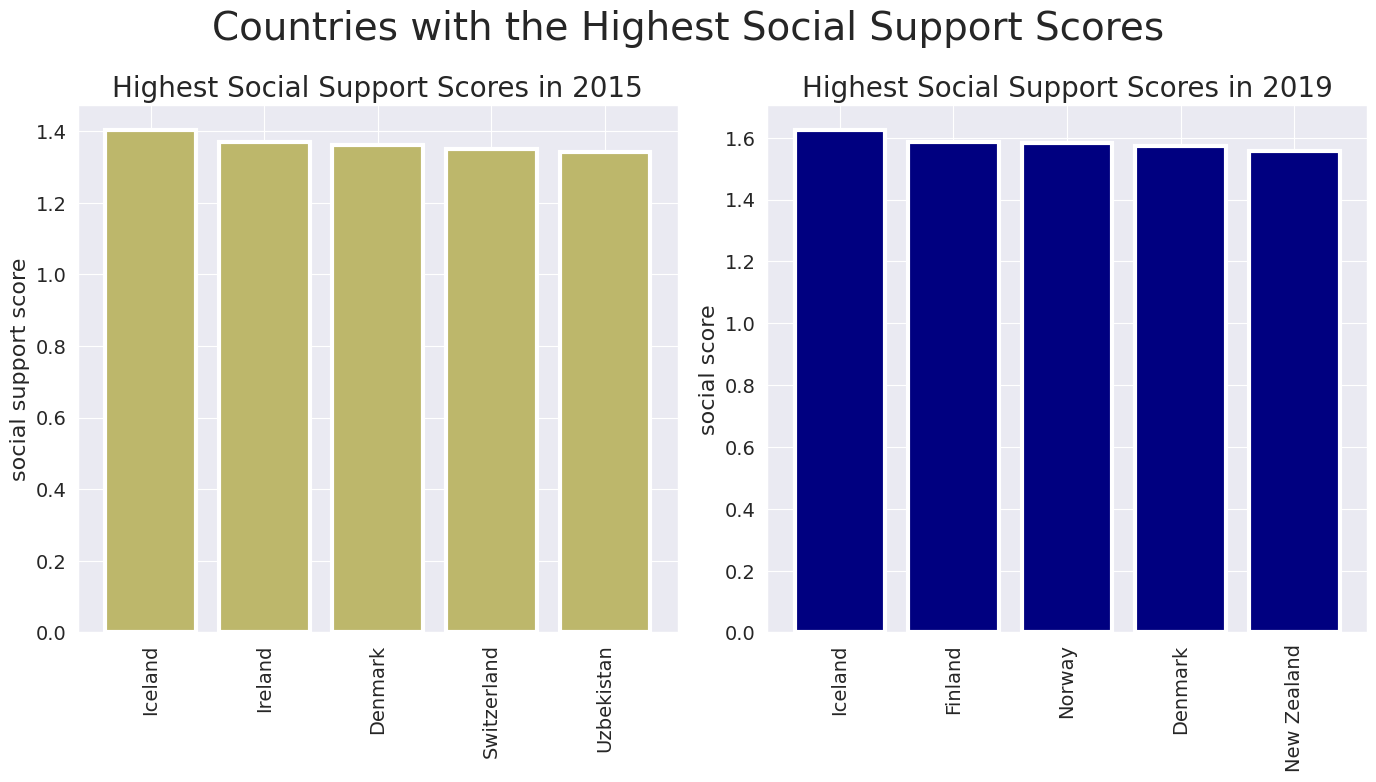

In [190]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,8))

social_scores15 = social_scores.copy().sort_values(by=['2015_social_score'],ascending=False).head()

ax1.bar(social_scores15['country'],social_scores15['2015_social_score'],color='darkkhaki',linewidth=3)
ax1.set_title('Highest Social Support Scores in 2015',fontsize=20)
ax1.set_ylabel('social support score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

social_scores19 = social_scores.copy().sort_values(by=['2019_social_score'],ascending=False).head()

ax2.bar(social_scores19['country'],social_scores19['2019_social_score'],color='navy',linewidth=3)
ax2.set_title('Highest Social Support Scores in 2019',fontsize=20)
ax2.set_ylabel('social score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Highest Social Support Scores",fontsize=28)

plt.tight_layout()

Let's see if Western Europe is the area with the highest average social support score or not.

In [191]:
social_region_score = social_scores.groupby('region')['2015_social_score'].mean().reset_index(name='social2015').sort_values(['social2015'],ascending=False)
sscore16 = social_scores.groupby('region')['2016_social_score'].mean().reset_index(name='social2016').sort_values(['social2016'],ascending=False)
sscore17 = social_scores.groupby('region')['2017_social_score'].mean().reset_index(name='social2017').sort_values(['social2017'],ascending=False)
sscore18 = social_scores.groupby('region')['2018_social_score'].mean().reset_index(name='social2018').sort_values(['social2018'],ascending=False)
sscore19 = social_scores.groupby('region')['2019_social_score'].mean().reset_index(name='social2019').sort_values(['social2019'],ascending=False)

social_region_score = social_region_score.merge(sscore16,on=['region'])
social_region_score = social_region_score.merge(sscore17,on=['region'])
social_region_score = social_region_score.merge(sscore18,on=['region'])
social_region_score = social_region_score.merge(sscore19,on=['region'])

social_region_score

region  social2015  social2016  social2017  \
0        Australia and New Zealand    1.314450    1.138770    1.529119   
1                    North America    1.284860    1.071960    1.450635   
2                   Western Europe    1.256163    1.053662    1.457878   
3                     Eastern Asia    1.115552    0.916530    1.304615   
4      Latin America and Caribbean    1.107415    0.901517    1.296089   
5       Central and Eastern Europe    1.054854    0.864694    1.284942   
6                Southeastern Asia    0.965773    0.822013    1.249948   
7  Middle East and Northern Africa    0.911999    0.695644    1.095511   
8               Sub-Saharan Africa    0.806855    0.596425    0.980731   
9                    Southern Asia    0.645321    0.480694    0.931875   

   social2018  social2019  
0    1.587000    1.552500  
1    1.501500    1.481000  
2    1.489750    1.483900  
3    1.331250    1.323500  
4    1.339200    1.332850  
5    1.328964    1.340393  
6    1.285000    1.273500  
7    1.110842    1.148684  
8    0.963871    0.938097  
9    0.974429    0.986857

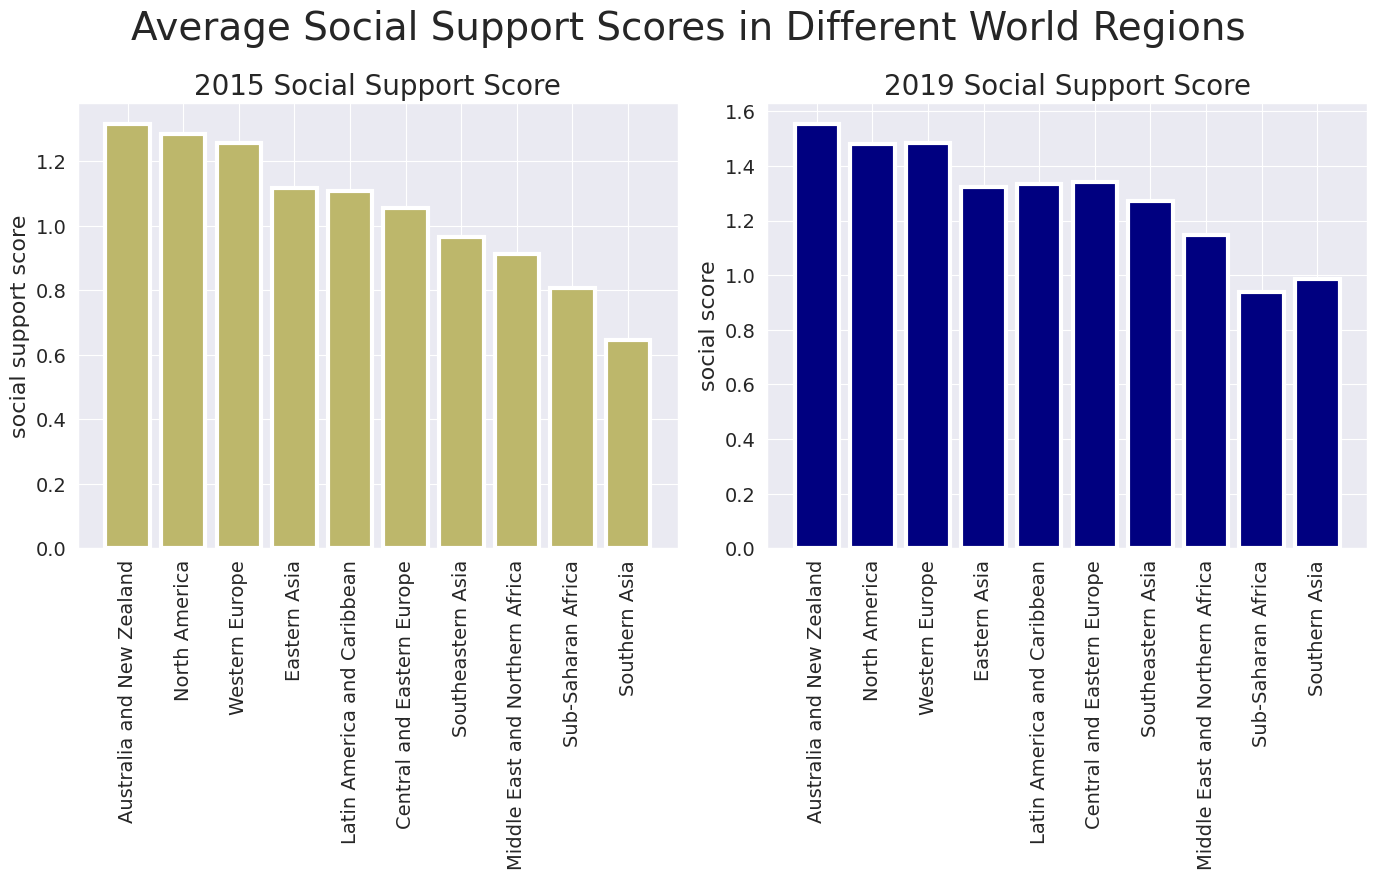

In [192]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,9))

ax1.bar(social_region_score['region'],social_region_score['social2015'],color='darkkhaki',linewidth=3)
ax1.set_title('2015 Social Support Score',fontsize=20)
ax1.set_ylabel('social support score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

ax2.bar(social_region_score['region'],social_region_score['social2019'],color='navy',linewidth=3)
ax2.set_title('2019 Social Support Score',fontsize=20)
ax2.set_ylabel('social score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Average Social Support Scores in Different World Regions",fontsize=28)

plt.tight_layout()

I have to be honest: these results are very difficult to believe. How can a region like North America, where there is no universal healthcare and little welfare state, have an average social support score higher than that of Western Europe?

### **4.8 Trust/Perceptions of Corruption**

Trust has a medium correlation level with freedom. All the correlations to the other variables are small. Therefore there could be surprising entries at the highest positions of the trust chart.

In [193]:
trust_scores = pd.DataFrame()
t16 = pd.DataFrame()
t17 = pd.DataFrame()
t18 = pd.DataFrame()
t19 = pd.DataFrame()

trust_scores[['country','region','2015_trust_score','2015_score']] = data15[['Country','Region','Trust (Government Corruption)','Happiness Score']]
t16[['country','2016_trust_score','2016_score']] = data16[['Country','Trust (Government Corruption)','Happiness Score']]
t17[['country','2017_trust_score','2017_score']] = data17[['Country','Trust..Government.Corruption.','Happiness.Score']]
t18[['country','2018_trust_score','2018_score']] = data18[['Country or region','Perceptions of corruption','Score']]
t19[['country','2019_trust_score','2019_score']] = data19[['Country or region','Perceptions of corruption','Score']]

trust_scores = trust_scores.merge(t16,on=['country'])
trust_scores = trust_scores.merge(t17,on=['country'])
trust_scores = trust_scores.merge(t18,on=['country'])
trust_scores = trust_scores.merge(t19,on=['country'])

trust_scores.head(5)

country          region  2015_trust_score  2015_score  \
0  Switzerland  Western Europe           0.41978       7.587   
1      Iceland  Western Europe           0.14145       7.561   
2      Denmark  Western Europe           0.48357       7.527   
3       Norway  Western Europe           0.36503       7.522   
4       Canada   North America           0.32957       7.427   

   2016_trust_score  2016_score  2017_trust_score  2017_score  \
0           0.41203       7.509          0.367007       7.494   
1           0.14975       7.501          0.153527       7.504   
2           0.44453       7.526          0.400770       7.522   
3           0.35776       7.498          0.315964       7.537   
4           0.31329       7.404          0.287372       7.316   

   2018_trust_score  2018_score  2019_trust_score  2019_score  
0             0.357       7.487             0.343       7.480  
1             0.138       7.495             0.118       7.494  
2             0.408       7.555             0.410       7.600  
3             0.340       7.594             0.341       7.554  
4             0.291       7.328             0.308       7.278

In [194]:
#Initializing the data variable
data = dict(type = 'choropleth',
            locations = trust_scores['country'],
            locationmode = 'country names',
            autocolorscale = False,
            colorscale = 'viridis',
            text = trust_scores['country'],
            z = trust_scores['2015_trust_score'],
            colorbar = {'title':'trust score','len':0.75,'lenmode':'fraction'})

#Initializing the object for graph_objs.Figure class
trust_map = gobj.Figure(data=[data])

trust_map.update_layout(title_text = 'Trust Score by Country (Year 2015)')

#plotting the map
iplot(trust_map)

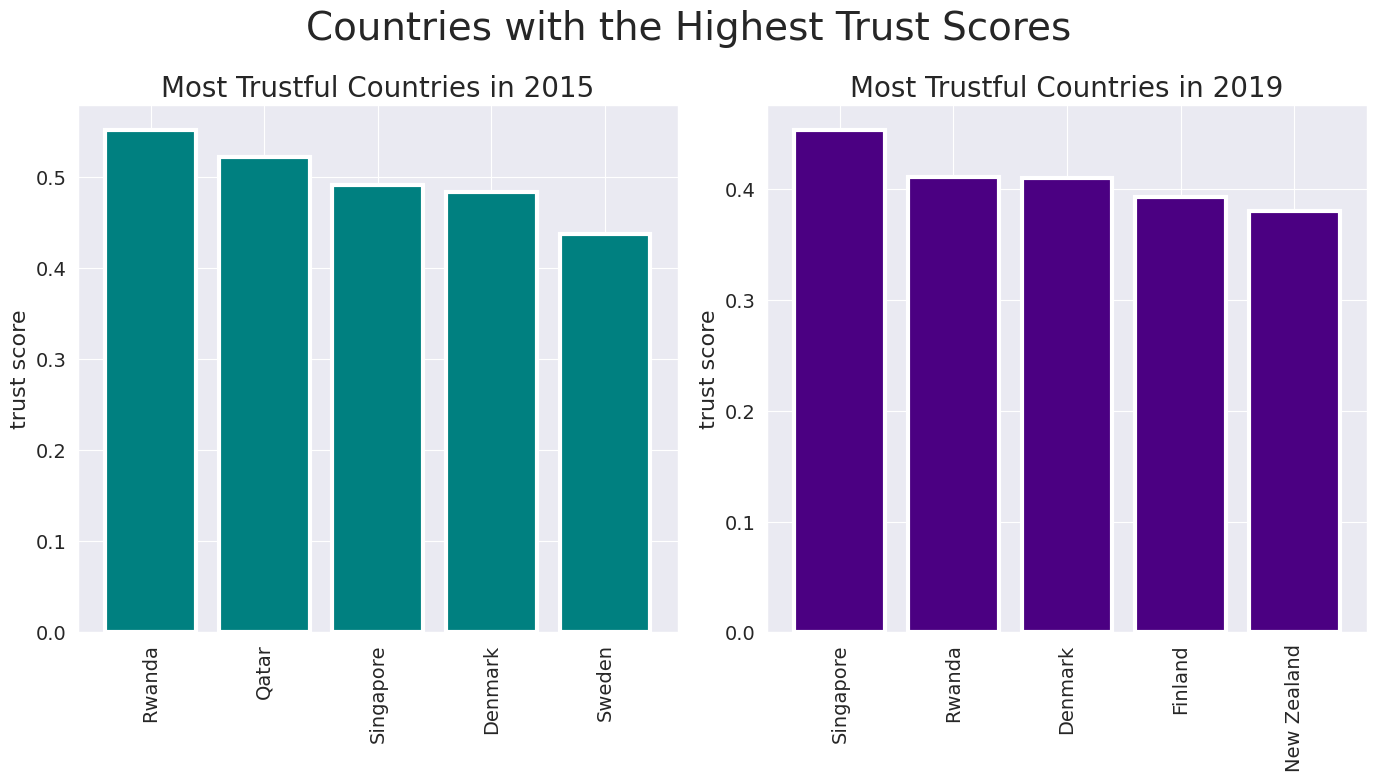

In [195]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,8))

trust_scores15 = trust_scores.copy().sort_values(by=['2015_trust_score'],ascending=False).head()

ax1.bar(trust_scores15['country'],trust_scores15['2015_trust_score'],color='teal',linewidth=3)
ax1.set_title('Most Trustful Countries in 2015',fontsize=20)
ax1.set_ylabel('trust score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

trust_scores19 = trust_scores.copy().sort_values(by=['2019_trust_score'],ascending=False).head()

ax2.bar(trust_scores19['country'],trust_scores19['2019_trust_score'],color='indigo',linewidth=3)
ax2.set_title('Most Trustful Countries in 2019',fontsize=20)
ax2.set_ylabel('trust score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Highest Trust Scores",fontsize=28)

plt.tight_layout()

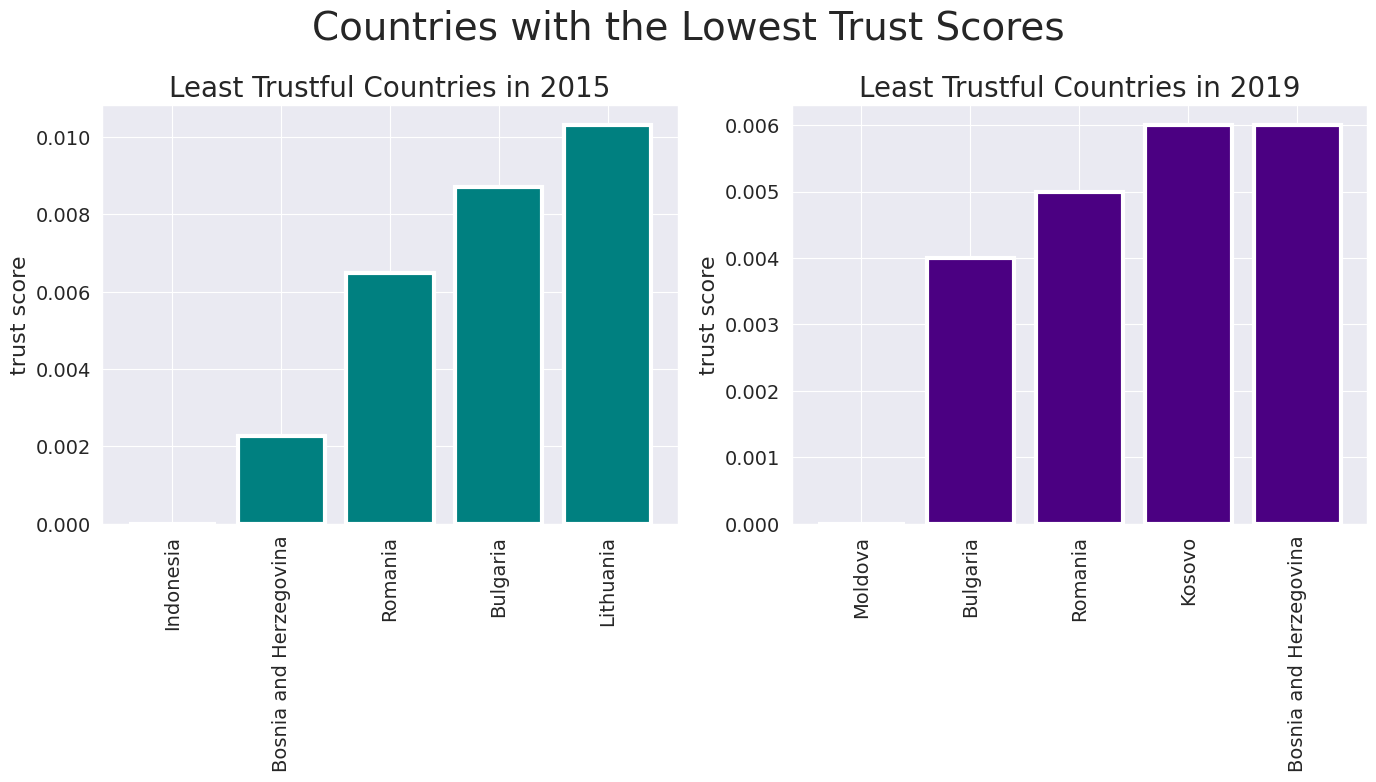

In [196]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,8))

trust_scores15 = trust_scores.copy().sort_values(by=['2015_trust_score'],ascending=True).head()

ax1.bar(trust_scores15['country'],trust_scores15['2015_trust_score'],color='teal',linewidth=3)
ax1.set_title('Least Trustful Countries in 2015',fontsize=20)
ax1.set_ylabel('trust score',fontsize=16)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.xaxis.set_tick_params(labelsize=14)

trust_scores19 = trust_scores.copy().sort_values(by=['2019_trust_score'],ascending=True).head()

ax2.bar(trust_scores19['country'],trust_scores19['2019_trust_score'],color='indigo',linewidth=3)
ax2.set_title('Least Trustful Countries in 2019',fontsize=20)
ax2.set_ylabel('trust score',fontsize=16)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.xaxis.set_tick_params(labelsize=14)

fig.suptitle("Countries with the Lowest Trust Scores",fontsize=28)

plt.tight_layout()

The trust score values of Indonesia and Moldova are super low or maybe even zero. They could be typos. Let's check the scores of these countries for all the years in the 2015-2019 range to see if these numbers are reliable or not.

In [197]:
trust_scores[trust_scores['country'] == 'Indonesia']

country             region  2015_trust_score  2015_score  \
67  Indonesia  Southeastern Asia               0.0       5.399   

    2016_trust_score  2016_score  2017_trust_score  2017_score  \
67           0.00322       5.314          0.015317       5.262   

    2018_trust_score  2018_score  2019_trust_score  2019_score  
67             0.018       5.093             0.028       5.192

In [198]:
trust_scores[trust_scores['country'] == 'Moldova']

country                      region  2015_trust_score  2015_score  \
47  Moldova  Central and Eastern Europe           0.01615       5.889   

    2016_trust_score  2016_score  2017_trust_score  2017_score  \
47           0.01903       5.897          0.010091       5.838   

    2018_trust_score  2018_score  2019_trust_score  2019_score  
47               0.0        5.64               0.0       5.529

These numbers confirm that what is shown in the histogram is correct. There are several countries with trust scores that are almost compatible with zero.

# **Act**

After analyzing the data, it is time to ask ourselves some questions.

First of all, the happiness score is not a true quantitative measure, like the GDP of a country, but it is a quantity that relies on a high level of interpretation. Secondly, there is a high level of risk of collecting biased data from the surveyed populations.

1. The populations that are more patriotic than the world average (if that could be measured somehow) are expected to inflate the perspectives on their country. On the contrary, populations that are below the world average of patriotism are expected to complain more about their country's situation.
2. In relation with the previous point, we can also argue that the populations of countries with more recent successes or advances (in terms of economy, great sport successes, and so on) are expected to answer more positively, while there could be populations of more 'stagnant' or static countries that, although being relatively prosperous, might answer negatively because "We used to live so much better in the past ..."
3. Some important factors might have been overlooked, the most important being the climate. It is indeed reasonable to ask ourselves if a country that is up north, so dark and cold during the winter, can be really happy. For example, it is well known that the suicide rate in extremely cold countries can be very high.

# **Statistical Analysis**

### **1. Variables Distribution (2015 Data)**

First, let's have a look at some basics statistical informations.

In [135]:
data15.describe()

Happiness Rank  Happiness Score  Standard Error  \
count      158.000000       158.000000      158.000000   
mean        79.493671         5.375734        0.047885   
std         45.754363         1.145010        0.017146   
min          1.000000         2.839000        0.018480   
25%         40.250000         4.526000        0.037268   
50%         79.500000         5.232500        0.043940   
75%        118.750000         6.243750        0.052300   
max        158.000000         7.587000        0.136930   

       Economy (GDP per Capita)      Family  Health (Life Expectancy)  \
count                158.000000  158.000000                158.000000   
mean                   0.846137    0.991046                  0.630259   
std                    0.403121    0.272369                  0.247078   
min                    0.000000    0.000000                  0.000000   
25%                    0.545808    0.856823                  0.439185   
50%                    0.910245    1.029510                  0.696705   
75%                    1.158448    1.214405                  0.811013   
max                    1.690420    1.402230                  1.025250   

          Freedom  Trust (Government Corruption)  Generosity  \
count  158.000000                     158.000000  158.000000   
mean     0.428615                       0.143422    0.237296   
std      0.150693                       0.120034    0.126685   
min      0.000000                       0.000000    0.000000   
25%      0.328330                       0.061675    0.150553   
50%      0.435515                       0.107220    0.216130   
75%      0.549092                       0.180255    0.309883   
max      0.669730                       0.551910    0.795880   

       Dystopia Residual  
count         158.000000  
mean            2.098977  
std             0.553550  
min             0.328580  
25%             1.759410  
50%             2.095415  
75%             2.462415  
max             3.602140

It is interesting to see what are the mean values of the variables (mean) and what is their 'spread', which is given by their standard deviations (std). We can also see what are their minimum and maximum values. Finally, we can see where the first (25%), second (50%, the median) and third (75%) quartiles are located.

Now, we can plot the variable distributions to see what their shapes are.

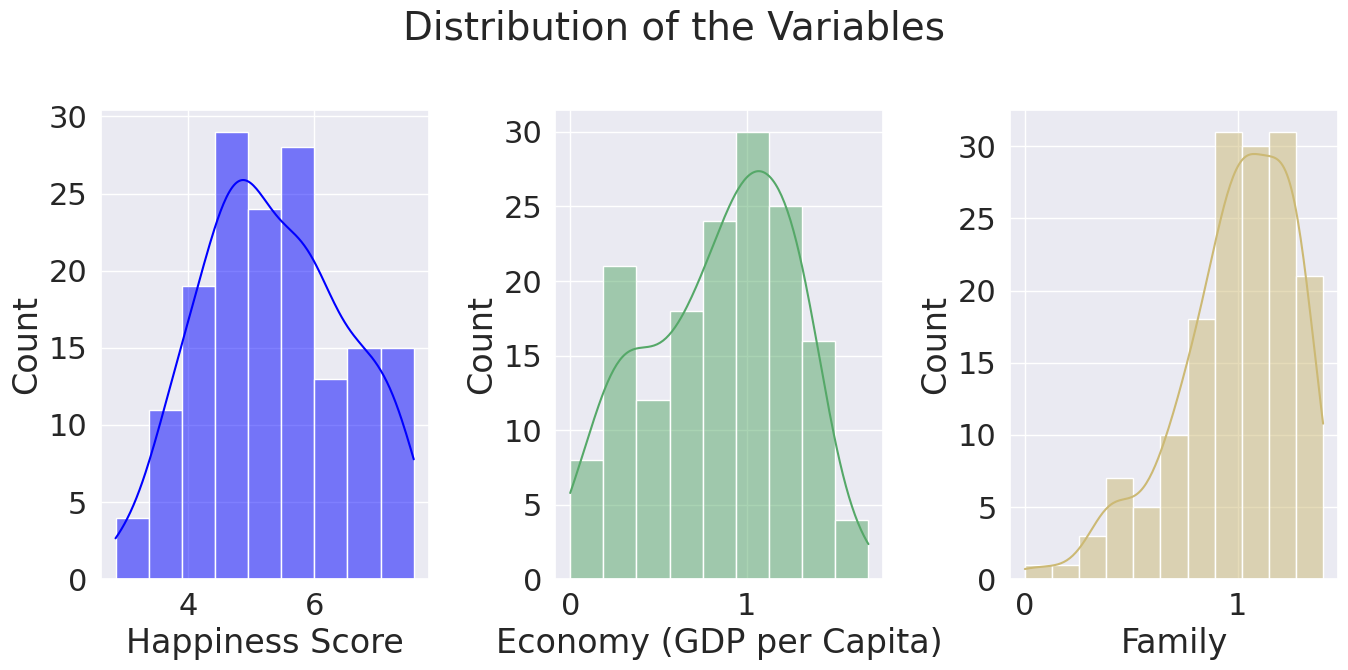

In [136]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(14,7))

ax1 = sns.histplot(data15['Happiness Score'],kde=True,color='blue',ax=ax1)
ax2 = sns.histplot(data15['Economy (GDP per Capita)'],kde=True,color='g',ax=ax2)
ax3 = sns.histplot(data15['Family'],kde=True,color='y',ax=ax3)

fig.suptitle("Distribution of the Variables",fontsize=28)

plt.tight_layout()

None of the above distributions is a 'perfect' Gaussian. In particular, the third one ('Family', also known as 'Social Support') is strongly left-skewed.

Let's have a look at the following two.

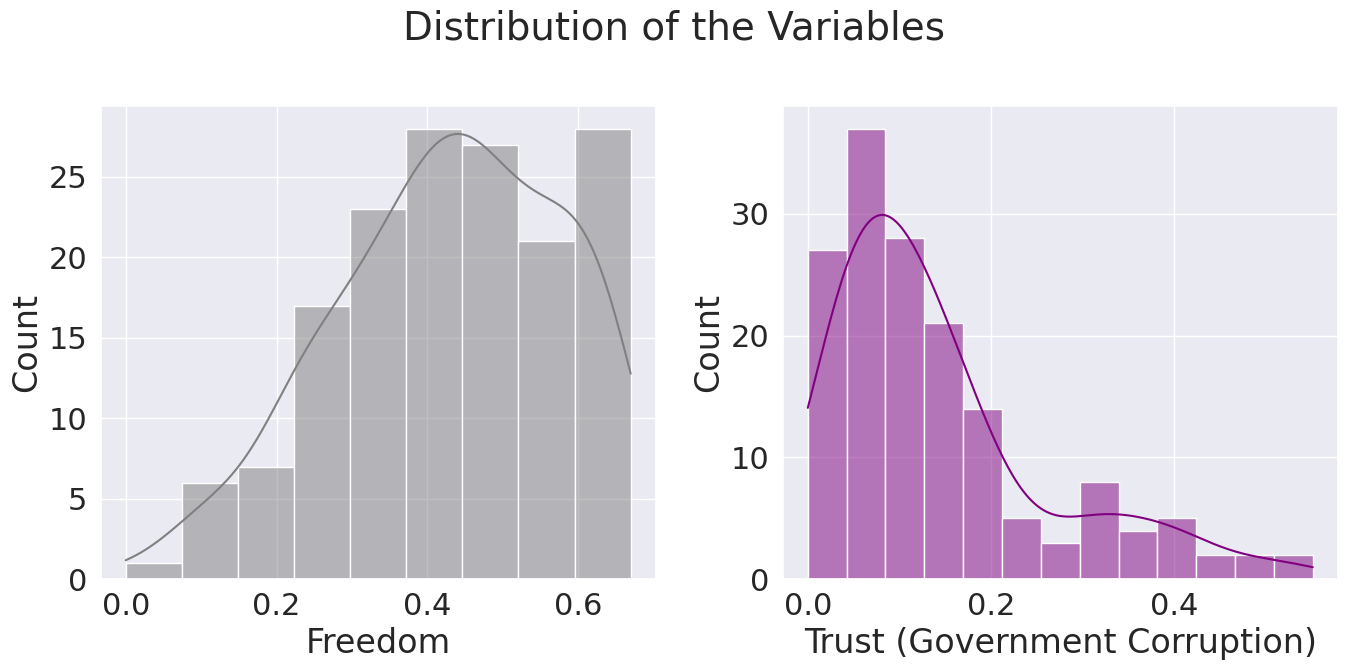

In [137]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,7))

ax1 = sns.histplot(data15['Freedom'],kde=True,color='grey',ax=ax1)
ax2 = sns.histplot(data15['Trust (Government Corruption)'],kde=True,color='purple',ax=ax2)

fig.suptitle("Distribution of the Variables",fontsize=28)

plt.tight_layout()

Again, we have skewed distributions. In particular, the variable 'Trust' is clearly right-skewed, which means that low values are dominant. In other words, the majority of people in the world do not trust their government.

Let's have a look at the last three variables.

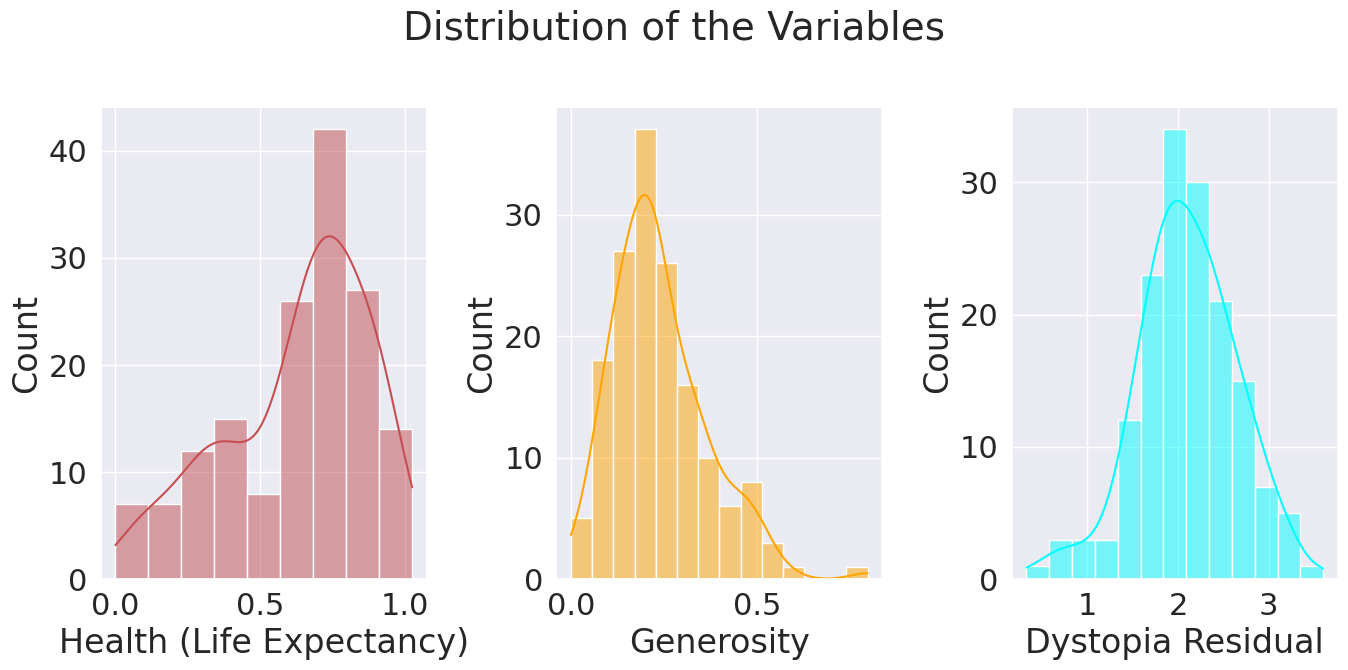

In [138]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(14,7))

ax1 = sns.histplot(data15['Health (Life Expectancy)'],kde=True,color='r',ax=ax1)
ax2 = sns.histplot(data15['Generosity'],kde=True,color='orange',ax=ax2)
ax3 = sns.histplot(data15['Dystopia Residual'],kde=True,color='cyan',ax=ax3)

fig.suptitle("Distribution of the Variables",fontsize=28)

plt.tight_layout()

Among the distributions that we have seen, that of 'Dystopia Residual' is the closest to a Gaussian distribution.

In [139]:
data15.columns

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')

### **Outliers**

I am plotting the boxplots of the variables to see what is their quartile distribution and, most important, to find out whether they have outliers or not. These informations may help in the regression analysis, when we will have to decide whether to impute these outliers or not.

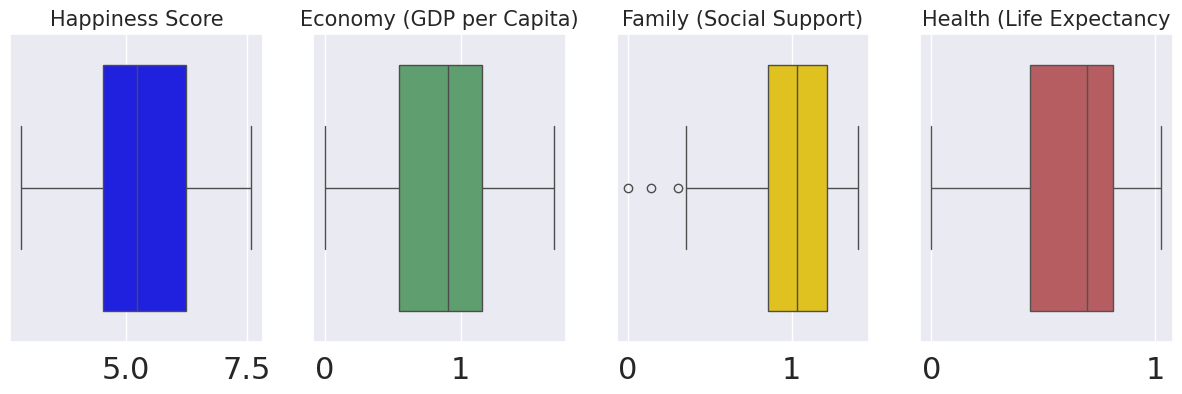

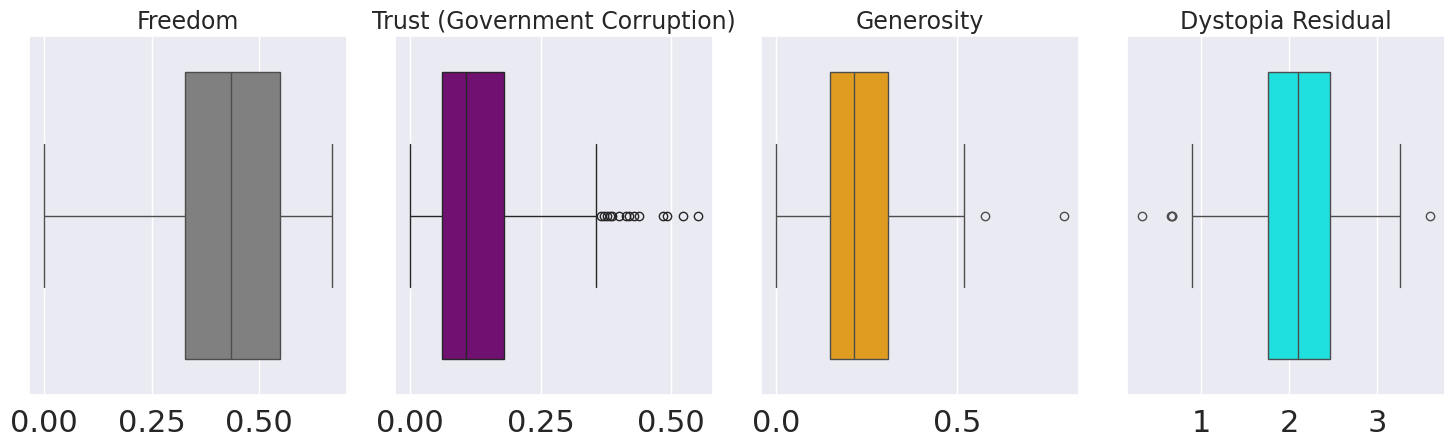

In [140]:
#fig = plt.figure(figsize=(10,7));
(topfig,bottomfig) = fig.subfigures(2,1);

topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,4,figsize=(15,4));
axes[0] = sns.boxplot(x=data15['Happiness Score'],ax=axes[0],color='blue')
axes[0].set_title('Happiness Score',fontsize=15);
axes[0].set_xlabel('',fontsize=1);
axes[1] = sns.boxplot(x=data15['Economy (GDP per Capita)'],ax=axes[1],color='g')
axes[1].set_title('Economy (GDP per Capita)',fontsize=15);
axes[1].set_xlabel('',fontsize=1);
axes[2] = sns.boxplot(x=data15['Family'],ax=axes[2],color='gold')
axes[2].set_title('Family (Social Support)',fontsize=15);
axes[2].set_xlabel('',fontsize=1);
axes[3] = sns.boxplot(x=data15['Health (Life Expectancy)'],ax=axes[3],color='r')
axes[3].set_title('Health (Life Expectancy',fontsize=15);
axes[3].set_xlabel('',fontsize=1);

bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,4,figsize=(15,5));
axes[0] = sns.boxplot(x=data15['Freedom'],ax=axes[0],color='grey')
axes[0].set_title('Freedom',fontsize=17);
axes[0].set_xlabel('',fontsize=1);
axes[1] = sns.boxplot(x=data15['Trust (Government Corruption)'],ax=axes[1],color='purple')
axes[1].set_title('Trust (Government Corruption)',fontsize=17);
axes[1].set_xlabel('',fontsize=1);
axes[2] = sns.boxplot(x=data15['Generosity'],ax=axes[2],color='orange')
axes[2].set_title('Generosity',fontsize=17);
axes[2].set_xlabel('',fontsize=1);
axes[3] = sns.boxplot(x=data15['Dystopia Residual'],ax=axes[3],color='cyan')
axes[3].set_title('Dystopia Residual',fontsize=17);
axes[3].set_xlabel('',fontsize=1);

plt.tight_layout()

Some of our variables have outliers:

1. Family/Social Support has outliers is the left part of the boxplot, which means that there are some countries where the social support is exceptionally low.
2. On the contrary, Trust has outliers on the right side, which means that the countries with high trust (i.e. low perception of corruption) are somehow the exceptions.
3. Geneosity is similar: very few countries display a very high generosity, which is thus perceived as an exception.

### **2. 2015 and 2019 Happiness Scores: Hypothesis Testing**

 It is interesting to find out if the 2015 and the 2019 'Happiness Score' mean values are statistically different or not. In other words, we want to find out if the global situation has changed in 5 years or not.

Let's state or null (H0) and alternative (HA) hypotheses.

H0: the 2015 and 2019 'Happiness Score' means are the same.

HA: the 2015 and 2019 'Happiness Score' means are NOT the same.

---
Then, let's choose our confidence level. It will be a standard 95% (α=0.05). Also, let's assume that the 2015 and 2019 samples are independent (as they should).

Let's perform a z-test. Recall that a z-distribution is often used in statistical methods in place of a t-distribution when the sample sizes are sufficiently large.

**Two-sample z-test**

Let's start with a z-test. The z-test is best used for greater-than-30 samples because, under the central limit theorem, as the number of samples gets larger, the samples are considered to be approximately normally distributed.

Let's print the 2015 and 2019 mean values of the Happiness Score and also their difference.

In [141]:
mean15 = data15['Happiness Score'].mean()
mean19 = data19['Score'].mean()
delta_mean = mean19 - mean15

print('mean 2015 = {:.3f}; mean 2019 = {:.3f}; mean 2019 - mean 2015 = {:.3f}'.format(mean15,mean19,delta_mean))

mean 2015 = 5.376; mean 2019 = 5.407; mean 2019 - mean 2015 = 0.031


The means are very similar, but not identical. Let's print the standard deviations.

In [142]:
std15 = data15['Happiness Score'].std()
std19 = data19['Score'].std()

print('std 2015 = {:.3f}; std 2019 = {:.3f}'.format(std15,std19))

std 2015 = 1.145; std 2019 = 1.113


And print the size of the two samples.

In [143]:
n15 = len(data15)
n19 = len(data19)

print('n15 = {}; n19 = {}'.format(n15,n19))

n15 = 158; n19 = 156


Now, let's first calculate the z-test score analytically and then compare it to the statistic module result, that we will get later.

In [144]:
z_test_an = (mean15 - mean19 - 0) / np.sqrt(std15**2/n15 + std19**2/n19)

print('z_test_an = {:.3f}'.format(z_test_an))

z_test_an = -0.246


The area of the standard normal distribution corresponding to a z‐score of –0.25 is 0.401 [for example, see https://statisticsbyjim.com/hypothesis-testing/z-table ]. Because this test is two‐tailed, that number must be doubled to yield a probability (p-value) of 0.802 that the population means are the same.

Now, let's do the same calculation by means of statsmodels.

In [145]:
print(sm.stats.ztest(data15['Happiness Score'],data19['Score']))

(np.float64(-0.2460525618551496), np.float64(0.8056415444348092))


This result is substantially the same as the previous one (I have made some approximations in the analytical calculation). The first number is the z-value, the second is the p-value.

The p-value has to be compared to our α=0.05 value (corresponding to a 95% confidence level). As p-value > α, we fail to reject the null hypothesis that there is no difference between the two mean values for the Happiness Score.

In other words, the H0 hypothesis is true and the means for the 2015 and 2019 Happiness Scores are (statistically) the same.

The confidence interval for the 2015 and 2019 means difference is:

In [146]:
z_star = 1.96 # z_star value for a 95% confidence interval

lower_limit = delta_mean - z_star * np.sqrt(std15**2/n15 + std19**2/n19)
upper_limit = delta_mean + z_star * np.sqrt(std15**2/n15 + std19**2/n19)

print('confidence interval for the means difference = ({:.3f}, {:.3f})'.format(lower_limit,upper_limit))

confidence interval for the means difference = (-0.218, 0.281)


The confidence interval includes the value of 0. Again, this means that the difference between the 2015 and 2019 means of the happiness score is compatible with zero.

It would be even more interesting to do this kind of test for the years 2019 and 2020, i.e. to see if the pandemic of COVID19 has changed the world (happiness) balance or not.

### **3. 2015 and 2019 European GDP Scores: Hypothesis Testing**

 It is interesting to find out if the 2015 and 2019 Western European 'GDP Score' mean values are statistically different or not. In other words, we want to find out if the economic situation in Western Europe has changed in 5 years or not.

Let's state or null (H0) and alternative (HA) hypotheses.

H0: the 2015 and 2019 European 'GDP Score' means are the same.

HA: the 2015 and 2019 European 'GDP Score' means are NOT the same.

Then, let's choose our confidence level. It will be a standard 95% (α = 0.05). Also, let's assume that the 2015 and 2019 samples are independent (as they should).

Now, let's perform a t-test. We have to do this because the number of European countries might not be large enough for a z-test.

**Two-sample t-test**

First, let's create a list of the Western European countries (data19 does not have this information).

In [147]:
western_europe = []

for country in data15[data15['Region'] == 'Western Europe']['Country']:
    western_europe.append(country)

Now, let's print the 2015 and 2019 mean values of the Western European GDP Score and also their difference.

In [148]:
mean_gdp_europe15 = data15[data15['Region'] == 'Western Europe']['Economy (GDP per Capita)'].mean()
mean_gdp_europe19 = data19[data19['Country or region'].isin(western_europe)]['GDP per capita'].mean()
delta_gdp = mean_gdp_europe19 - mean_gdp_europe15

print('GDP mean 2015 = {:.3f}; GDP mean 2019 = {:.3f}; GDP mean 2019 - GDP mean 2015 = {:.3f}'.format(mean_gdp_europe15,mean_gdp_europe19,delta_gdp))

GDP mean 2015 = 1.299; GDP mean 2019 = 1.362; GDP mean 2019 - GDP mean 2015 = 0.063


As anticipated, the 2015 and 2019 Western European GDP Scores are quite different. What we want to find out is if this difference is statistically significant or not.

First, we need the (pooled) standard error, *std_err.*

In [149]:
std15 = data15[data15['Region'] == 'Western Europe']['Economy (GDP per Capita)'].std()
std19 = data19[data19['Country or region'].isin(western_europe)]['GDP per capita'].std()

n15 = len(data15[data15['Region'] == 'Western Europe'])
n19 = len(data19[data19['Country or region'].isin(western_europe)])

sp = np.sqrt(((n15-1)*std15**2+(n19-1)*std19**2)/(n15+n19-2))

std_err = sp * np.sqrt(1/n15 + 1/n19)

print('pooled standard error = {:.3f}'.format(std_err))

pooled standard error = 0.031


Here, df = n15 + n19 - 2 = 39 is the number of degrees of freedom for the two-sample mean test.

Then, we are getting our t value.

In [150]:
t = delta_gdp / std_err

print('t-value = {:.3f}'.format(t))

t-value = 2.080


We have to compare this calculated value of t to the reference value of a t-distribution, corresponding to the case of df = 39 and α = 0.05. We can find this value e.g. on a statistics course table. We get t∗(0.05,39)= 2.023.

We observe that t = 2.080 > t∗ = 2.023. We therefore conclude that we can reject the null hypothesis that the 2015 and 2019 Western European mean GDP scores are the same and conclude that there is evidence that the mean GDP score of Western Europe has changed between 2015 and 2019.

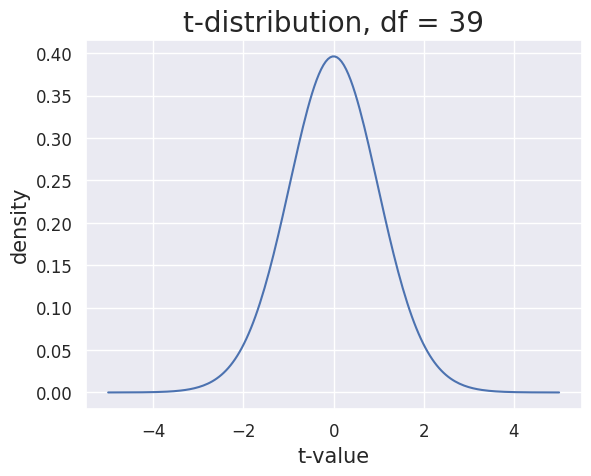

In [151]:
import scipy.stats as stats

XX = np.linspace(-5,5,200)

# Generate t-distribution for a specific choice of df
YY = stats.t.pdf(XX,df=39)

plt.title('t-distribution, df = 39',fontsize=20)
plt.xlabel('t-value',fontsize=15)
plt.ylabel('density',fontsize=15)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.plot(XX,YY);

Now, we can calculate the confidence interval for the two mean difference ...

In [152]:
t_star = 2.023

lower_limit_gdp = delta_gdp - t_star * std_err
upper_limit_gdp = delta_gdp + t_star * std_err

print('confidence interval for the gdp means difference = ({:.3f}, {:.3f})'.format(lower_limit_gdp,upper_limit_gdp))

confidence interval for the gdp means difference = (0.002, 0.125)


... and observe that the interval does not contain 0, because the two GDP score mean values are (statistically) different.

Finally, we can perform the t-test by means of the sm.stats module and see if the result coincides with what we have got before. We obtain:

In [153]:
print(sm.stats.ttest_ind(data19[data19['Country or region'].isin(western_europe)]['GDP per capita'],data15[data15['Region'] == 'Western Europe']['Economy (GDP per Capita)']))

(np.float64(2.0802028057056705), np.float64(0.04412501433258086), np.float64(39.0))


These are the calculated t-value, the p-value and the number of degrees of freedom, df. The t-value coincides with our analytic result. Regarding the p-value, we can say that p-value = 0.044 <  
α = 0.05. Because of this, we can reject the null hypothesis.

# **Multiple Regression Analysis**

**Assumptions of Multiple Linear Regression**

Before we can start with our multiple regression analysis, we need to make some checks. First of all, it is useful to draw scatterplots for all the possible variable couplings.

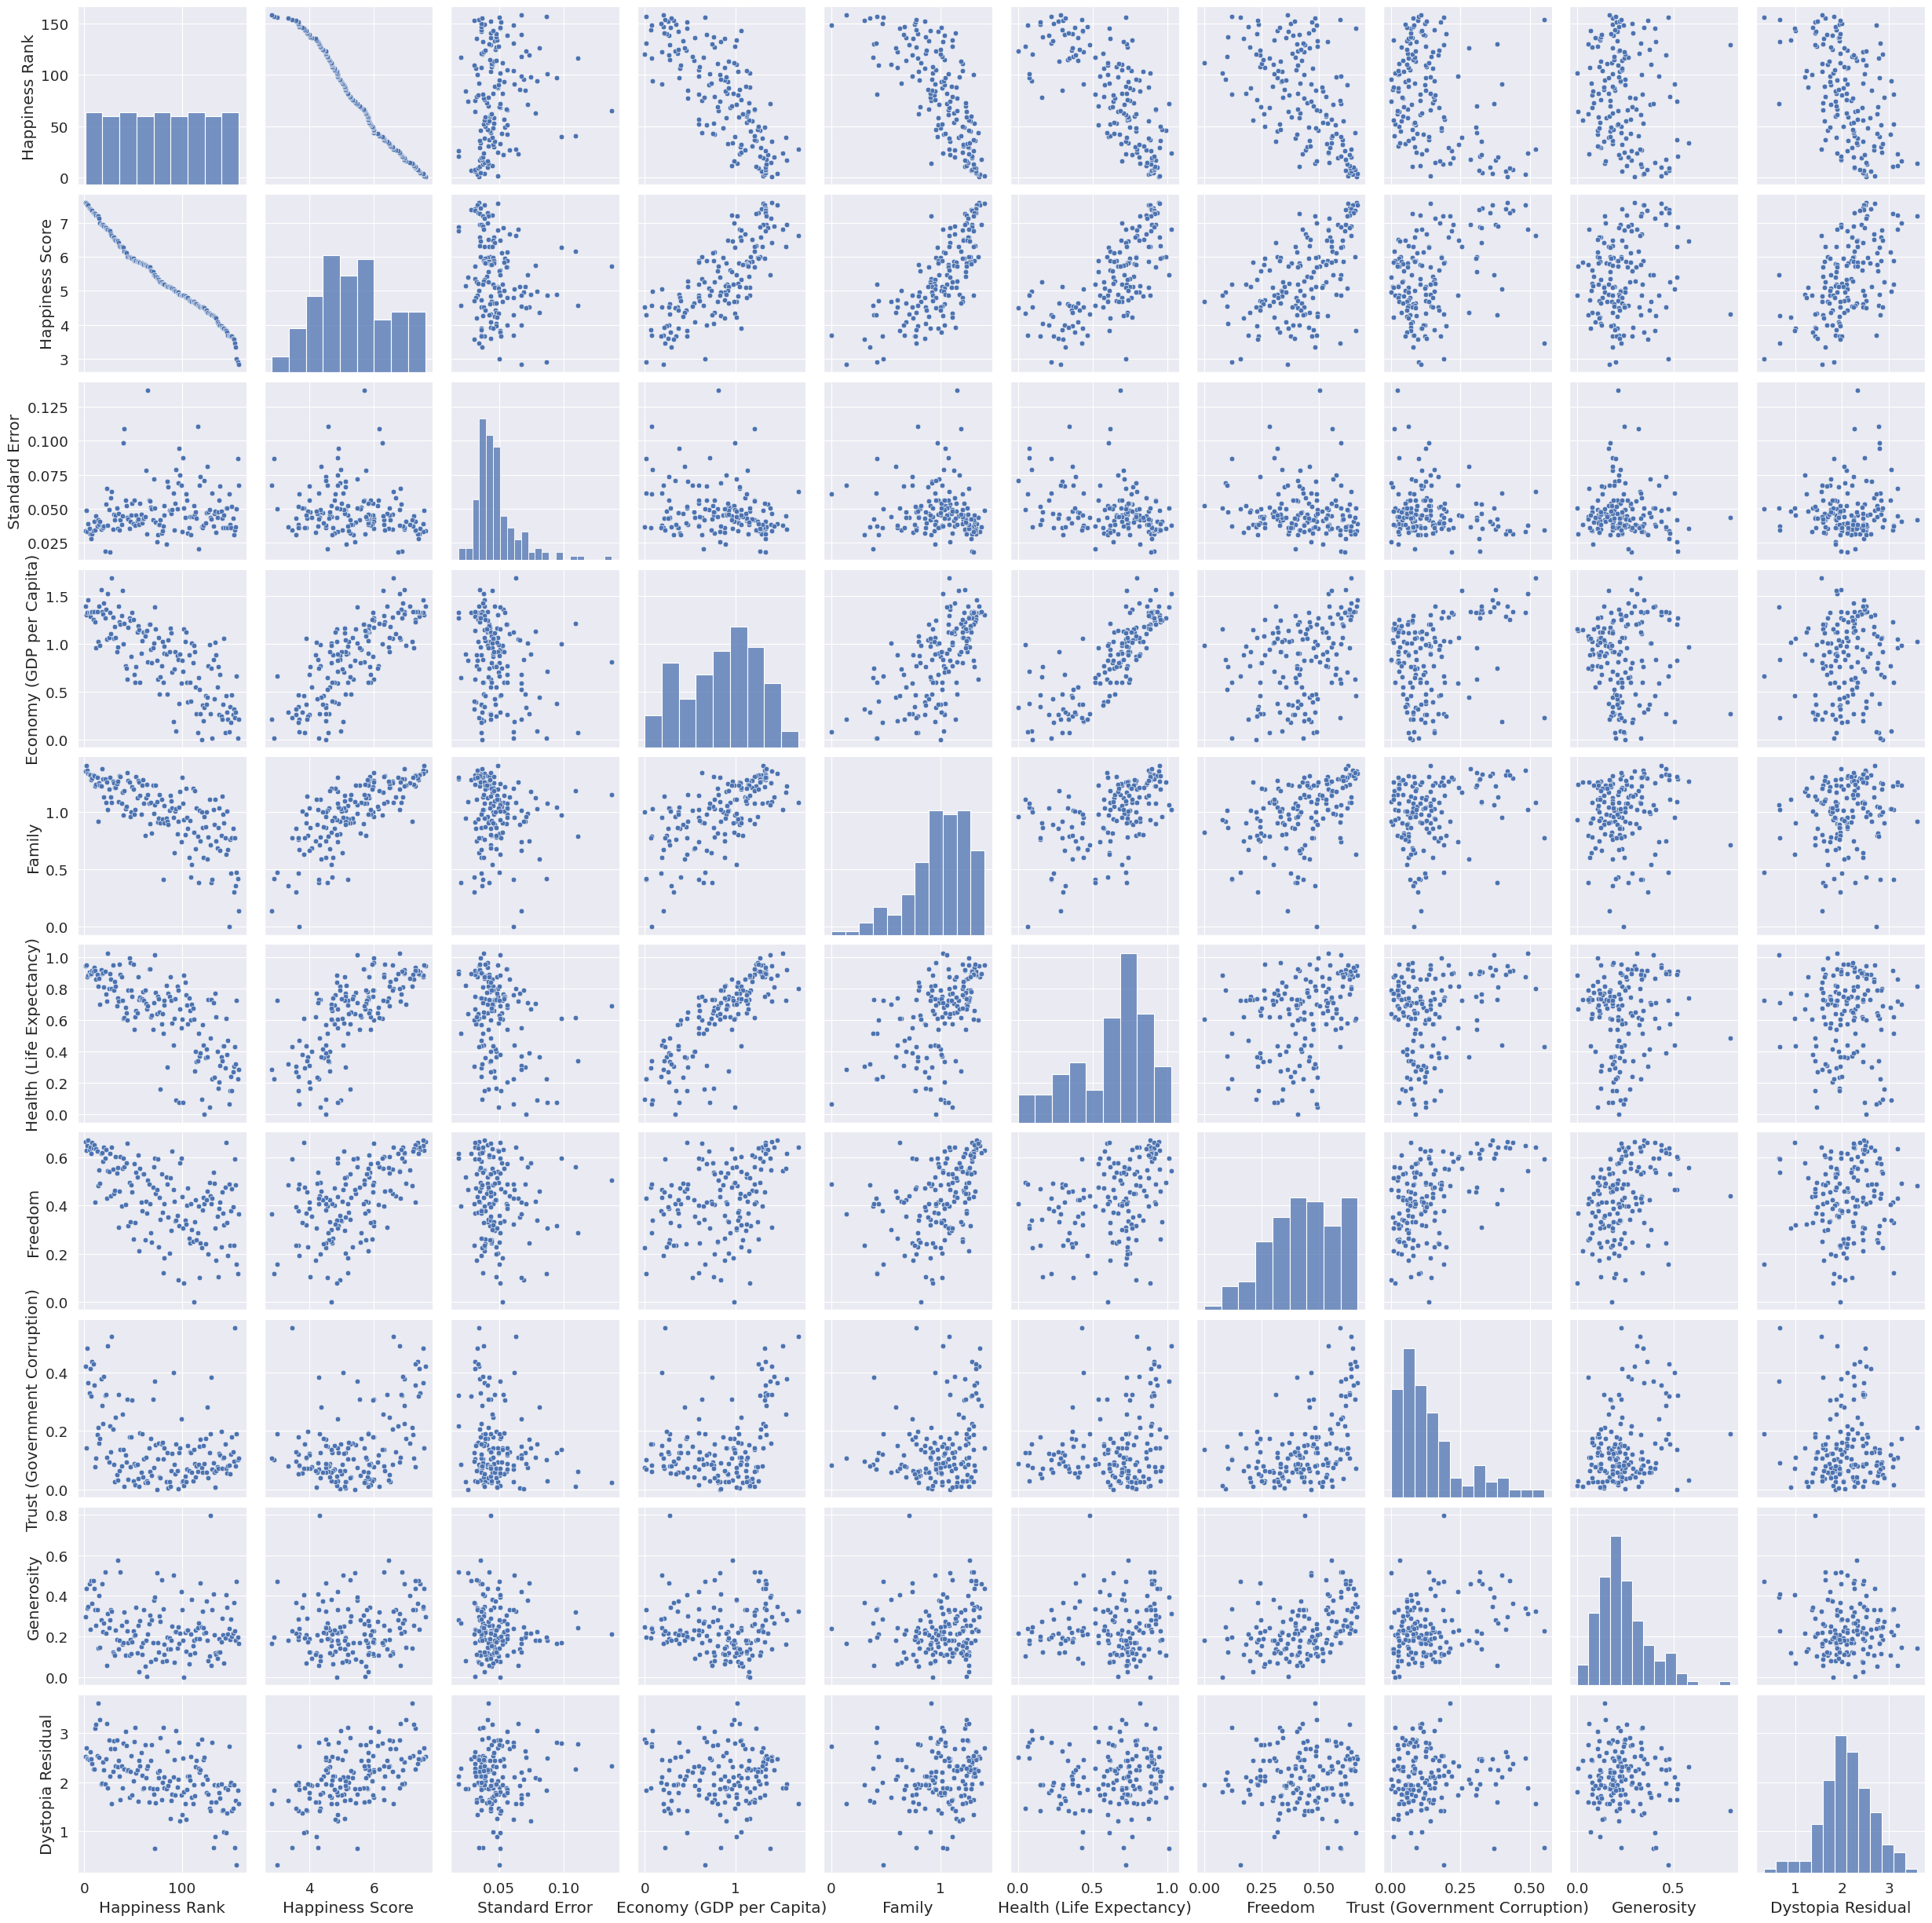

In [154]:
sns.set_context("paper",font_scale=1.5)
sns.pairplot(data15)

These plots can help us to start thinking about the main assumptions associated with a linear regression model.

1. Linearity. The relationship between x and the mean of y is linear.
2. Homoscedasticity. The variance of residual is the same for any value of x.
3. Independence. Observations are independent of each other.
4. Normality. For any fixed value of x, y is normally distributed.
5. No multicollinearity. It is essential that the independent variables are not too highly correlated with each other. The correlation coefficients should ideally be below 0.80.

Let's have a look a the first row, which is associated to the target variable Happiness Score.

1. (Almost) by definition, Happiness Score and Happiness Rank are collinear. Thus one of them has to be dropped.
2. The Happiness Score is in a mild-to-strong linear relationship with some of the predictor variables, notably Economy, Family, Health and Freedom. Trust and Generosity exhibit a weak linear relation to the Happiness Score.
3. Some predictor variables seem to be relatively highly correlated with each other. This is the case of Economy vs Health. We will have to deal with this.

Let's see if by imputing the outliers we can improve the situation. But before doing it, we will drop the unnecessary features.

In [155]:
data15 = data15.drop(columns=['Happiness Rank','Standard Error'],axis=1)

data15

Country                           Region  Happiness Score  \
0    Switzerland                   Western Europe            7.587   
1        Iceland                   Western Europe            7.561   
2        Denmark                   Western Europe            7.527   
3         Norway                   Western Europe            7.522   
4         Canada                    North America            7.427   
..           ...                              ...              ...   
153       Rwanda               Sub-Saharan Africa            3.465   
154        Benin               Sub-Saharan Africa            3.340   
155        Syria  Middle East and Northern Africa            3.006   
156      Burundi               Sub-Saharan Africa            2.905   
157         Togo               Sub-Saharan Africa            2.839   

     Economy (GDP per Capita)   Family  Health (Life Expectancy)  Freedom  \
0                     1.39651  1.34951                   0.94143  0.66557   
1                     1.30232  1.40223                   0.94784  0.62877   
2                     1.32548  1.36058                   0.87464  0.64938   
3                     1.45900  1.33095                   0.88521  0.66973   
4                     1.32629  1.32261                   0.90563  0.63297   
..                        ...      ...                       ...      ...   
153                   0.22208  0.77370                   0.42864  0.59201   
154                   0.28665  0.35386                   0.31910  0.48450   
155                   0.66320  0.47489                   0.72193  0.15684   
156                   0.01530  0.41587                   0.22396  0.11850   
157                   0.20868  0.13995                   0.28443  0.36453   

     Trust (Government Corruption)  Generosity  Dystopia Residual  
0                          0.41978     0.29678            2.51738  
1                          0.14145     0.43630            2.70201  
2                          0.48357     0.34139            2.49204  
3                          0.36503     0.34699            2.46531  
4                          0.32957     0.45811            2.45176  
..                             ...         ...                ...  
153                        0.55191     0.22628            0.67042  
154                        0.08010     0.18260            1.63328  
155                        0.18906     0.47179            0.32858  
156                        0.10062     0.19727            1.83302  
157                        0.10731     0.16681            1.56726  

[158 rows x 10 columns]

We will keep Region as a categorical variable and we will use the column Country to label our regression model results for a final comparison with the original data.

**Outliers Imputation**

I am defining a function for outliers imputation.

In [156]:
def outlier_imputer(data,features):

    data_out = data.copy()

    for column in features:

        # First define the first and third quartiles
        Q1 = data_out[column].quantile(0.25)
        Q3 = data_out[column].quantile(0.75)
        # Define the inter-quartile range
        IQR = Q3 - Q1
        # ... and the lower/higher threshold values
        lowerL = Q1 - 1.5 * IQR
        higherL = Q3 + 1.5 * IQR

        # Impute 'left' outliers
        data_out.loc[data_out[column] < lowerL,column] = lowerL
        # Impute 'right' outliers
        data_out.loc[data_out[column] > higherL,column] = higherL

    return data_out

features = ['Family','Trust (Government Corruption)','Generosity','Dystopia Residual']

data15_clean = outlier_imputer(data15,features)

Let's check if the outliers imputation worked.

<Figure size 1000x700 with 0 Axes>

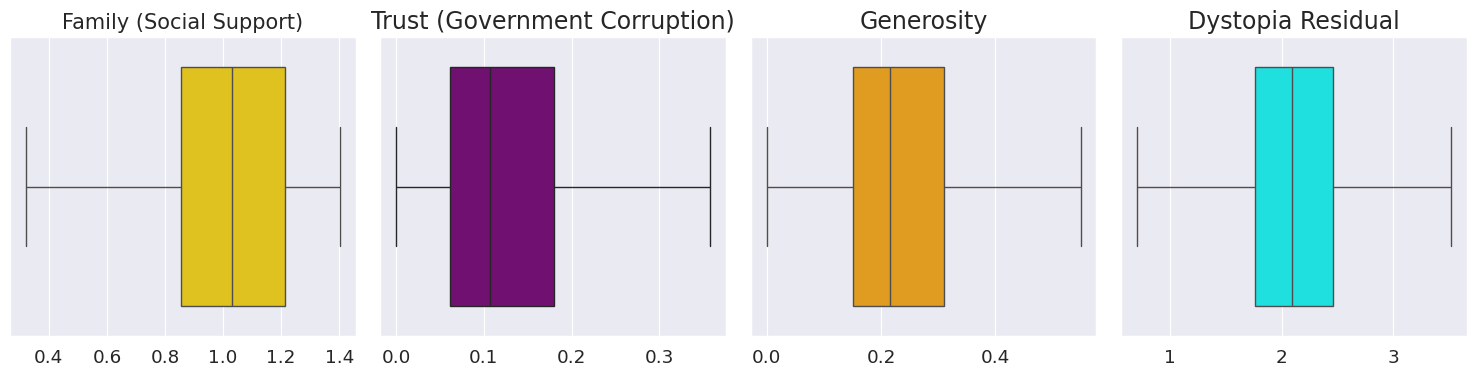

In [157]:
fig = plt.figure(figsize=(10,7));

fig,axes = plt.subplots(1,4,figsize=(15,4));
axes[0] = sns.boxplot(x=data15_clean['Family'],ax=axes[0],color='gold')
axes[0].set_title('Family (Social Support)',fontsize=15);
axes[0].set_xlabel('',fontsize=1);
axes[1] = sns.boxplot(x=data15_clean['Trust (Government Corruption)'],ax=axes[1],color='purple')
axes[1].set_title('Trust (Government Corruption)',fontsize=17);
axes[1].set_xlabel('',fontsize=1);
axes[2] = sns.boxplot(x=data15_clean['Generosity'],ax=axes[2],color='orange')
axes[2].set_title('Generosity',fontsize=17);
axes[2].set_xlabel('',fontsize=1);
axes[3] = sns.boxplot(x=data15_clean['Dystopia Residual'],ax=axes[3],color='cyan')
axes[3].set_title('Dystopia Residual',fontsize=17);
axes[3].set_xlabel('',fontsize=1);

plt.tight_layout();

Yes, it did. Now, let's see if the outliers imputation was beneficial for the Happiness Score level of correlation with Trust and Generosity.

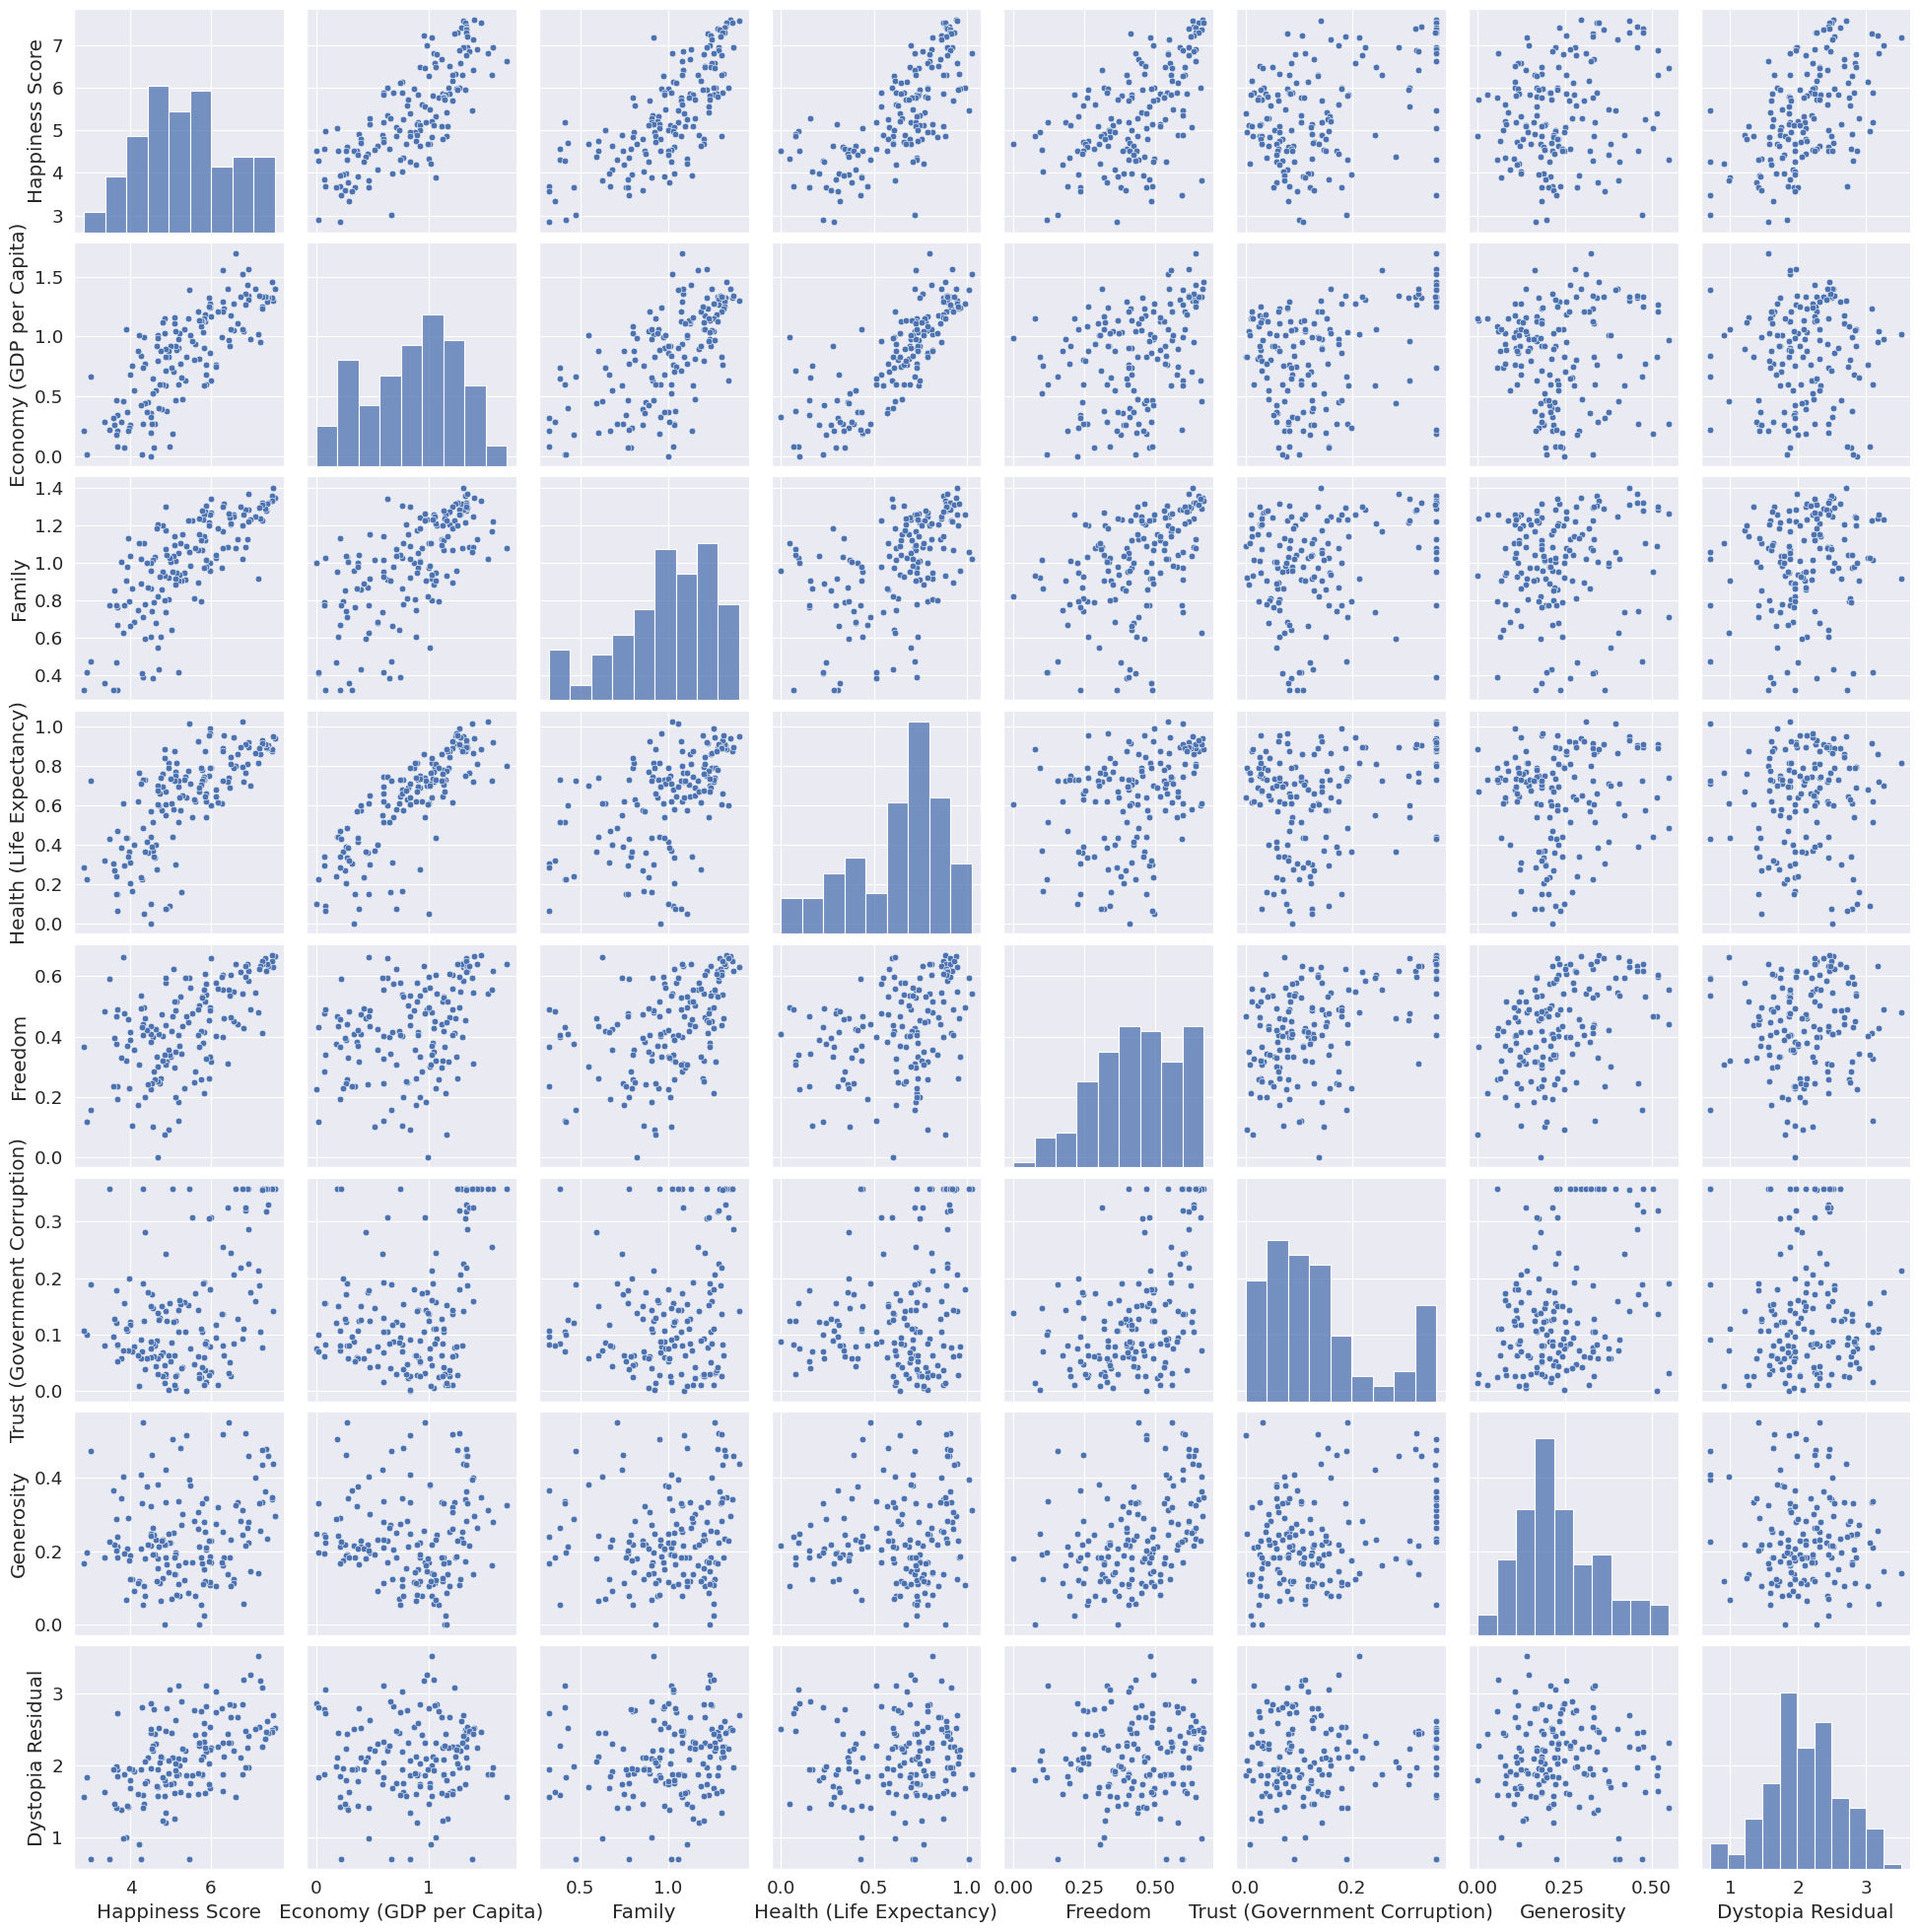

In [158]:
sns.set_context("paper",font_scale=1.5)
sns.pairplot(data15_clean)

Multiple Linear Regression with statsmodels

I am conducting a multiple linear regression analysis on the 2015 data.

First, I have to rename some columns.

In [159]:
data15_clean = data15_clean.rename({'Happiness Score':'Score', 'Economy (GDP per Capita)':'GDP','Health (Life Expectancy)':'Health','Trust (Government Corruption)':'Trust','Dystopia Residual':'Dystopia'},axis=1)

data15_clean.columns

Index(['Country', 'Region', 'Score', 'GDP', 'Family', 'Health', 'Freedom',
       'Trust', 'Generosity', 'Dystopia'],
      dtype='object')

I will try to use all the variables, including the categorical variable Region.

In [160]:
lg = sm.OLS.from_formula("Score ~ C(Region) + GDP + Family + Health + Freedom + Trust + Generosity + Dystopia",data15_clean)
res = lg.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4910.
Date:                Thu, 06 Nov 2025   Prob (F-statistic):          5.59e-185
Time:                        17:54:10   Log-Likelihood:                 254.57
No. Observations:                 158   AIC:                            -475.1
Df Residuals:                     141   BIC:                            -423.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -0.0985      0.062     -1.596      0.113      -0.220       0.023
C(Region)[T.Central and Eastern Europe]          0.0054      0.042      0.130      0.897      -0.077       0.088
C(Region)[T.Eastern Asia]                       -0.0071      0.044     -0.160      0.873      -0.095       0.080
C(Region)[T.Latin America and Caribbean]         0.0041      0.041      0.101      0.920      -0.077       0.085
C(Region)[T.Middle East and Northern Africa]    -0.0063      0.041     -0.154      0.878      -0.088       0.075
C(Region)[T.North America]                      -0.0193      0.052     -0.375      0.708      -0.121       0.082
C(Region)[T.Southeastern Asia]                   0.0693      0.043      1.618      0.108      -0.015       0.154
C(Region)[T.Southern Asia]                       0.0354      0.046      0.773      0.441      -0.055       0.126
C(Region)[T.Sub-Saharan Africa]                  0.0239      0.046      0.518      0.605      -0.067       0.115
C(Region)[T.Western Europe]                     -0.0034      0.039     -0.088      0.930      -0.080       0.073
GDP                                              0.9958      0.022     44.777      0.000       0.952       1.040
Family                                           1.0600      0.024     43.928      0.000       1.012       1.108
Health                                           1.0367      0.042     24.596      0.000       0.953       1.120
Freedom                                          0.9786      0.039     24.823      0.000       0.901       1.057
Trust                                            1.1501      0.051     22.741      0.000       1.050       1.250
Generosity                                       0.9414      0.045     20.822      0.000       0.852       1.031
Dystopia                                         1.0059      0.009    118.175      0.000       0.989       1.023
==============================================================================
Omnibus:                      118.001   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3001.143
Skew:                          -2.222   Prob(JB):                         0.00
Kurtosis:                      23.884   Cond. No.                         91.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is not working because the p-values of the categorical variable Region are too large (some of them are around 0.9). Thus I have to repeat the fit without this variable.

In [161]:
lg = sm.OLS.from_formula("Score ~ GDP + Family + Health + Freedom + Trust + Generosity + Dystopia",data15_clean)
res = lg.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.092e+04
Date:                Thu, 06 Nov 2025   Prob (F-statistic):          1.20e-199
Time:                        17:54:10   Log-Likelihood:                 247.54
No. Observations:                 158   AIC:                            -479.1
Df Residuals:                     150   BIC:                            -454.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0625      0.023     -2.683      0.008      -0.109      -0.016
GDP            0.9864      0.021     47.312      0.000       0.945       1.028
Family         1.0481      0.022     47.080      0.000       1.004       1.092
Health         1.0136      0.030     34.047      0.000       0.955       1.072
Freedom        1.0099      0.037     27.564      0.000       0.938       1.082
Trust          1.1162      0.048     23.489      0.000       1.022       1.210
Generosity     0.9801      0.039     25.085      0.000       0.903       1.057
Dystopia       1.0021      0.008    128.785      0.000       0.987       1.018
==============================================================================
Omnibus:                      125.601   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4077.065
Skew:                          -2.350   Prob(JB):                         0.00
Kurtosis:                      27.438   Cond. No.                         35.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

One can notice that:

1. The R2 value is almost 1. The fit is good.
2. All the p-values of the predictor variables (see the column P>|t|) are close to zero, which means that they are statistically significant.
3. The coefficients shown in the above summary table, like GDP, Family and Health, are all close to 1, with the exception of the intercept. Why?
This is because the Happiness Score of a nation is given by the algebraic sum of all the other scores (Family, Health, Trust ...). One can check this by considering a specific case, say Finland, and add all the partial scores. By doing this, one should get the nation's happiness score.

The happiness score of Finland is 7.406.

In [162]:
data15[data15['Country'] == 'Finland']

Country          Region  Happiness Score  Economy (GDP per Capita)  \
5  Finland  Western Europe            7.406                   1.29025   

    Family  Health (Life Expectancy)  Freedom  Trust (Government Corruption)  \
5  1.31826                   0.88911  0.64169                        0.41372   

   Generosity  Dystopia Residual  
5     0.23351            2.61955

Now, as a check, I am summing all the partial contributions to the happiness score, like Economy, Family, and so on. I should get the same result.

In [163]:
data15[data15['Country'] == 'Finland']['Economy (GDP per Capita)'] + data15[data15['Country'] == 'Finland']['Family'] + data15[data15['Country'] == 'Finland']['Health (Life Expectancy)'] + data15[data15['Country'] == 'Finland']['Freedom'] + data15[data15['Country'] == 'Finland']['Trust (Government Corruption)'] + data15[data15['Country'] == 'Finland']['Generosity'] + data15[data15['Country'] == 'Finland']['Dystopia Residual']

5    7.40609
dtype: float64